# Imports

In [367]:
# %pip install numpy
# %pip install opencv-python
# %pip install matplotlib

In [368]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import collections
from scipy.stats import linregress
import math
from PIL import Image, ImageTransform
from matplotlib import cm
from itertools import combinations
from enum import Enum

# Create objects

In [369]:
universal_pieces = []

In [370]:
class Pieces:
    piece_image_color = []
    piece_image_bw = []
    corners = []
    edges = []

In [371]:
class Edges:
    edge_image_color = []
    edge_image_bw = []
    shape = -1

In [372]:
class Shape(Enum):
    Hole = 0
    Head = 1
    Flat = 2

# Read Image

In [373]:
def show(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input)
    plt.show()

def show_multiple(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

def show_gray(img_input, name):
    plt.figure(figsize = (15,15))
    plt.axis("off")
    plt.title(name)
    plt.imshow(img_input, cmap='gray')
    plt.show()

def show_multiple_gray(img_input, names):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        plt.imshow(img_input[i], cmap='gray')
    plt.tight_layout()
    plt.show()

def show_multiple_mix(img_input, names, gray):
    plt.figure(figsize = (10*len(names),10))
    n = len(names)
    for i in range(n):
        plt.subplot(1, n, 1 + i)
        plt.axis("off")
        plt.title(names[i])
        if(gray[i]):
            plt.imshow(img_input[i], cmap='gray')
        else:
            plt.imshow(img_input[i])
    plt.tight_layout()
    plt.show()

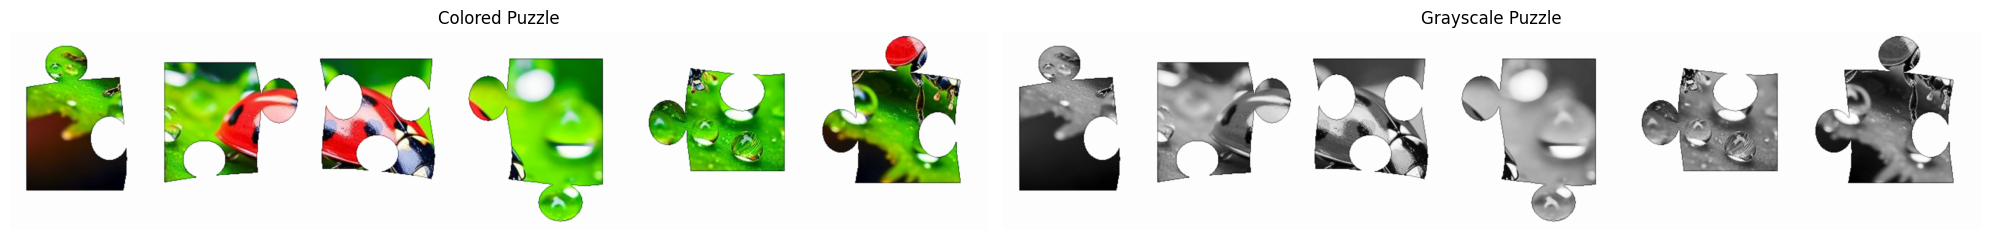

In [374]:

path = 'puzzles/ladybug.png'
img_orig = cv2.imread(path, 1)
img_color = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

show_multiple_mix([img_color, gray], ["Colored Puzzle", "Grayscale Puzzle"], [False, True])

# Remove background

In [375]:
#Colored Image
def remove_background(img_input, thresh):
    max = [0, 0, 0]
    std = [0, 0, 0]
    color_img_array = np.array(img_input)
    length, width, _ = color_img_array.shape
    new_image = np.zeros((length, width))

    color = [color_img_array[:,:,0].flatten(), color_img_array[:,:,1].flatten(), color_img_array[:,:,2].flatten()]
    c = ('r','g','b')
    for i, col in enumerate(color):
        histr, _ = np.histogram(col, bins=256, range=[0, 256])
        max[i] = histr.argmax()
        std[i] = np.std(col.flatten(), axis = 0)
    img_input = img_input.astype(int)
    stddev = [int(x*thresh) for x in std]
    for i in range(img_input.shape[0]):
        for j in range(img_input.shape[1]):
            changed = False
            pixel = img_input[i][j]
            if max[0] - stddev[0] < pixel[0] and pixel[0] <  max[0]+stddev[0]:
                if max[1] - stddev[1] < pixel[1] and pixel[1] <  max[1]+stddev[1]:
                    if max[2] - stddev[2] < pixel[2] and pixel[2] <  max[2]+stddev[2]:
                        new_image[i][j] = 0
                        changed = True
            if not changed:
                new_image[i][j] = 255
                
    return new_image
#Grayscale Image
def remove_gray_background(img_input, thresh):
    max = 0
    std = 0
    color = np.array(img_input)
    histr, _ = np.histogram(color, bins=256, range=[0, 256])
    max = histr.argmax()
    img_input = img_input.astype(int)
    stddev = std*thresh
    for i in range(img_input.shape[0]):
        for j in range(img_input.shape[1]):
            changed = False
            if max - stddev < img_input[i][j] and img_input[i][j] <  max+stddev:
                img_input[i][j] = 0
                changed = True
                        
            if not changed:
                img_input[i][j] = 255
    return img_input

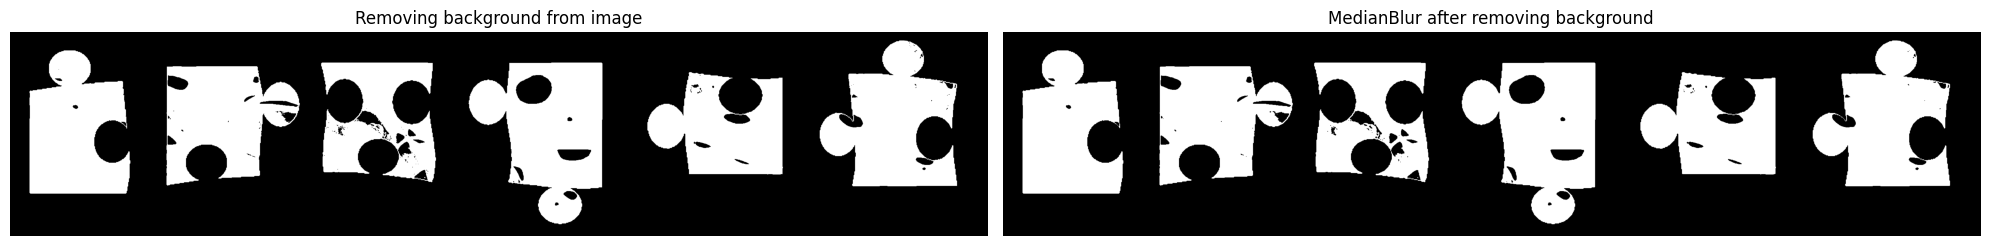

In [376]:
img_bg_removed = np.copy(img_color)
img_bg_removed = remove_background(img_bg_removed, 0.75)
img_bg_removed = np.pad(img_bg_removed, pad_width=10, mode="constant")
img_bg_removed = img_bg_removed.astype(np.uint8)
img_median = cv2.medianBlur(img_bg_removed, 3)
show_multiple_gray([img_bg_removed, img_median], ["Removing background from image", "MedianBlur after removing background"])

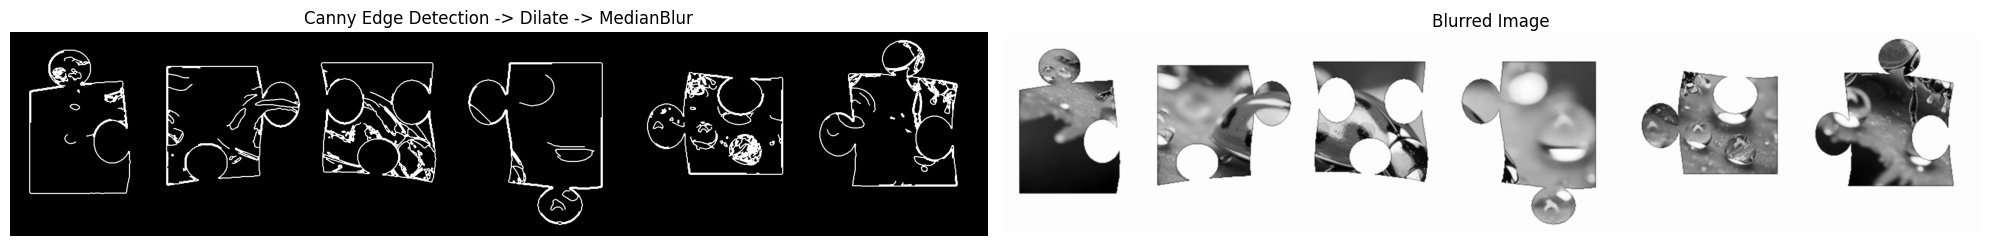

In [377]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
img_blur = cv2.GaussianBlur(gray, (3, 3), 0)
cannyedges = cv2.Canny(image=img_blur, threshold1=70, threshold2=200)
# cannyedges = cannyedges[1:cannyedges.shape[0]-1][1: cannyedges.shape[1]-1]
cannyedges = np.pad(cannyedges, pad_width= 10, mode="constant")
cannyedges = cv2.dilate(cannyedges, kernel)
cannyedges = cv2.medianBlur(cannyedges, 3)
show_multiple_mix([cannyedges, img_blur], ["Canny Edge Detection -> Dilate -> MedianBlur", "Blurred Image"], [True, True])

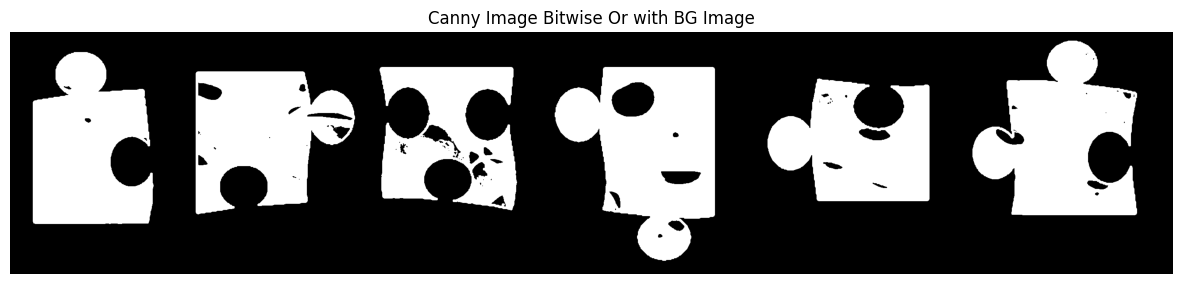

In [378]:
canny_bg_img = np.copy(img_median)
edges = np.copy(cannyedges)
for x in range(canny_bg_img.shape[0]):
    for y in range(canny_bg_img.shape[1]):
        if edges[x][y] != 0:
            canny_bg_img[x][y] = 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
# canny_bg_img = cv2.dilate(canny_bg_img, kernel)
show_gray(canny_bg_img, "Canny Image Bitwise Or with BG Image")

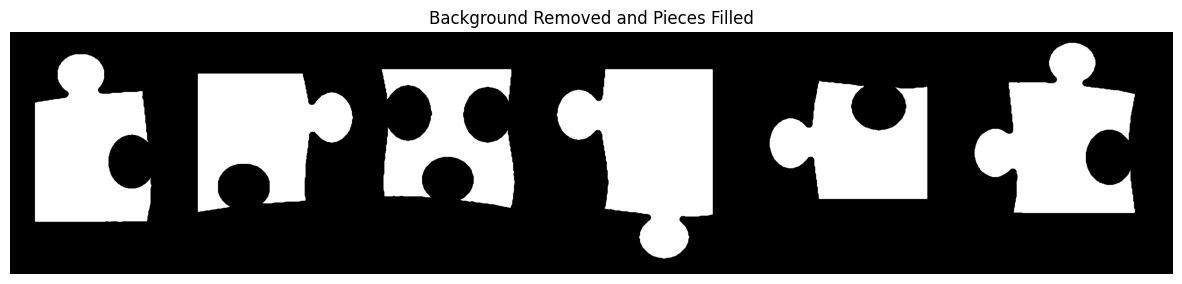

In [379]:
def get_background(is_background, img_compare):
    q = collections.deque([(0, 0)])
    visited = set((0, 0))
    dir = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    l, w = is_background.shape
    while q:
        x, y = q.popleft()
        is_background[x][y] = 1
        for dx, dy in dir:
            if -1 < x + dx and x + dx < l and -1 < y + dy and y + dy < w:
                if (img_compare[x+dx][y+dy] == 0).any():
                    if (x + dx, y + dy) not in visited:
                        q.append((x + dx, y + dy))
                        visited.add((x + dx, y + dy))
    return is_background

def fill_img(background, image):
    for x in range(background.shape[0]):
            for y in range(background.shape[1]):
                if not background[x][y]:
                    image[x][y] = 255
    return image

#get background of canny image + bg image
is_bg = get_background(np.zeros_like(np.array(cannyedges)), canny_bg_img)
filled_pieces = fill_img(is_bg, canny_bg_img)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
filled_pieces = cv2.dilate(filled_pieces, kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (17,17))
filled_pieces = cv2.erode(filled_pieces, kernel)
show_gray(filled_pieces, "Background Removed and Pieces Filled")


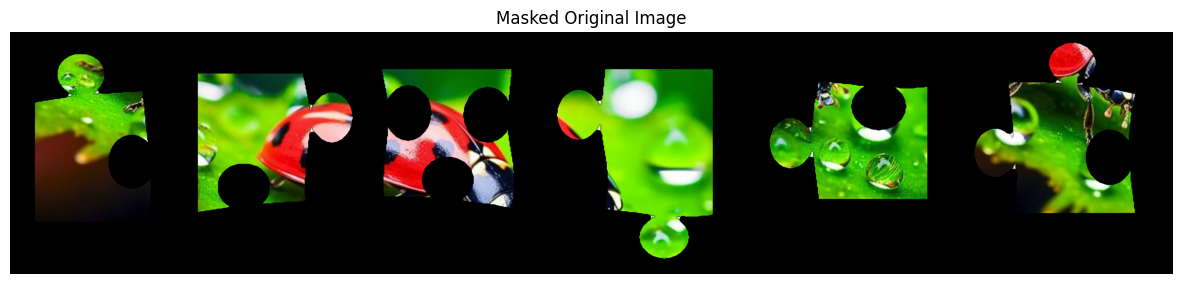

In [380]:
# img_array = cv2.imread('./puzzles/sandwiches.png')
img_seperated = np.copy(img_orig)
img_seperated = np.pad(img_seperated, pad_width=((10, 10), (10, 10), (0, 0)), mode="constant")
img_color_padded = np.pad(img_color, pad_width=((10, 10), (10, 10), (0, 0)), mode="constant")

filled_pieces = np.copy(filled_pieces)
for x in range(img_seperated.shape[0]):
    for y in range(img_seperated.shape[1]):
        if filled_pieces[x][y] == 0:
            img_seperated[x][y] = [0, 0, 0]
img_seperated = cv2.cvtColor(img_seperated, cv2.COLOR_BGR2RGB)
show(img_seperated, "Masked Original Image")

# Seperate Pieces

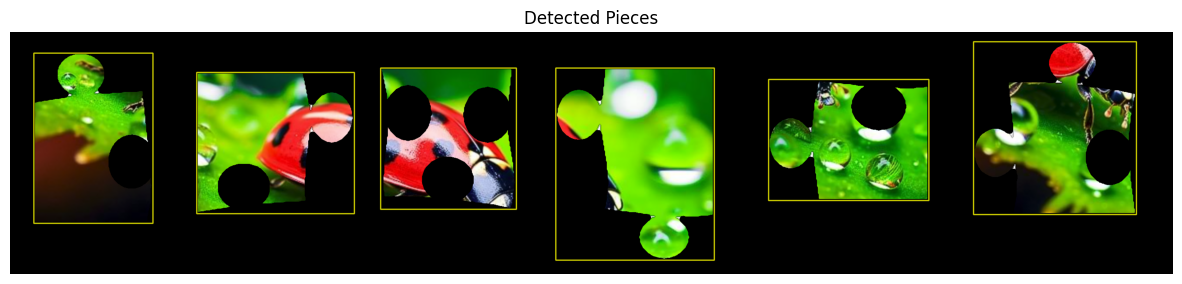

In [381]:
def detect_objects(image):
    universal_pieces.clear()
    pad =10
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes around each detected object
    img_with_boxes = np.copy(image)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 20 and h > 20:
            cv2.rectangle(img_with_boxes, (x-3, y-3), (x + w + 3, y + h + 3), (204, 204, 0), 2)
            #taking screenshots of the mask
            puzzle_piece = Pieces()
            puzzle_piece.piece_image_bw = filled_pieces[y-pad:y+h+pad, x-pad:x+w+pad]
            puzzle_piece.piece_image_color = img_color_padded[y-pad:y+h+pad, x-pad:x+w+pad]
            universal_pieces.append(puzzle_piece)
    return img_with_boxes

# Example usage: store pieces
image_pieces_detected = detect_objects(img_seperated)

# Display the result
show(image_pieces_detected, "Detected Pieces")

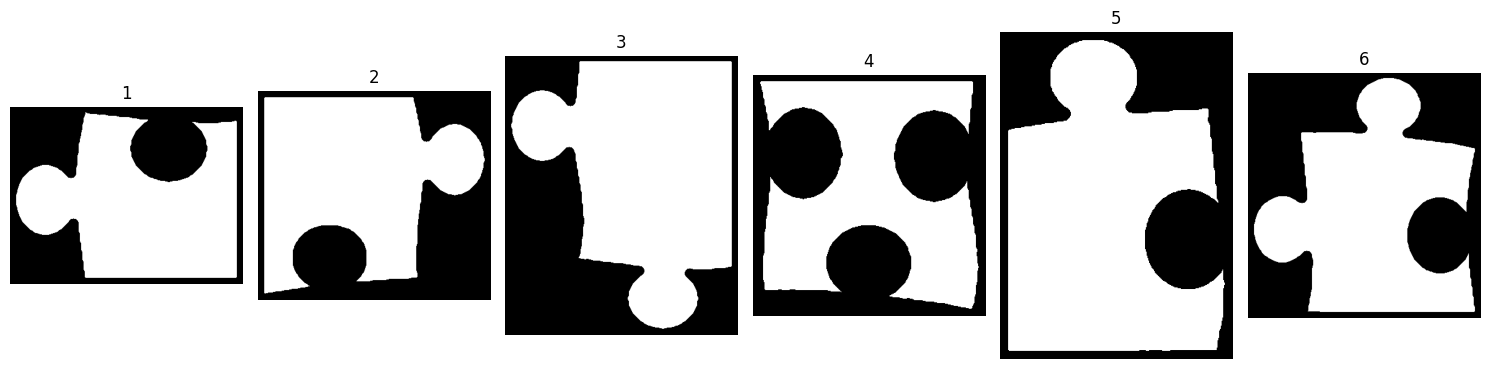

In [382]:
fig, axes = plt.subplots(nrows=1, ncols=len(universal_pieces), figsize=(15, 5))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_bw
    axes[i].imshow(image, cmap='gray')
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

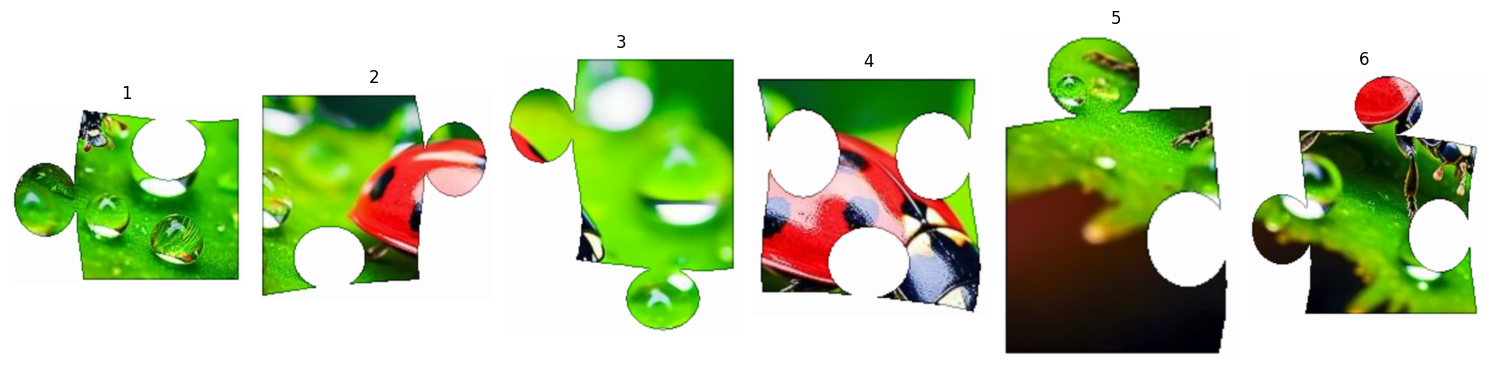

In [383]:
fig, axes = plt.subplots(nrows=1, ncols=len(universal_pieces), figsize=(15, 5))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_color
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [384]:
def connect_nearby(img, val):
    img_new = np.copy(img)
    img = np.pad(img, val+1,'constant', constant_values=(0, 0))
    diff_grid=[[0,1],[1,0],[0,-1],[-1,0]]
    diff_check= [[-1,0], [0,1],[1,0],[0,-1]]
    img_x, img_y = img.shape
    # print(img.shape)
    for x in range(img_x - val - val-2):
        x_val = x+val+1
        for y in range(img_y - val - val-2):
            y_val = y+val+1
            if(img[x_val][y_val]==255):
                for loop in range(val):
                    curr_x = x_val - (loop+1)
                    curr_y = y_val - (loop+1)
                    iterate = 8*(loop+1)
                    for i in range(iterate):
                        color =0
                        next = (int)(i/(iterate/4))
                        # print(str(curr_x)+ ", "+ str(curr_y))
                        if(i%(iterate/4)==0):
                            if(i ==0):
                                if(img[curr_x][curr_y-1]==255 | img[curr_x-1][curr_y-1]==255 | img[curr_x-1][curr_y]==255):
                                    color =255
                            elif(i== iterate/4):
                                if(img[curr_x-1][curr_y]==255 | img[curr_x-1][curr_y+1]==255 | img[curr_x][curr_y+1]==255):
                                    color =255
                            elif(i== iterate/2):
                                if(img[curr_x][curr_y+1]==255 | img[curr_x+1][curr_y+1]==255 | img[curr_x+1][curr_y]==255):
                                    color =255
                            else:
                                if(img[curr_x+1][curr_y]==255 | img[curr_x+1][curr_y-1]==255 | img[curr_x][curr_y-1]==255):
                                    color =255
                        else:
                            comp_x = curr_x+diff_check[next][0]
                            comp_y = curr_y+diff_check[next][1]
                            if(img[comp_x][comp_y]==255):
                                color=255
                        if(color==255):
                            cv2.line(img_new,(y_val-val-1,x_val-val-1), (curr_y-val-1,curr_x-val-1), 255,1 )
                            # img_new[curr_x-val-1][curr_y-val-1] = 255


                        curr_x = curr_x + diff_grid[next][0]
                        curr_y = curr_y + diff_grid[next][1]
                    
                # print(str(x_val)+ ", "+ str(y_val))
                # print(img[x_val][y_val])
    return img_new


In [385]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_bw
    erode_img_copy = cv2.erode(image, kernel)
    pieces_bound = image - erode_img_copy
    (universal_pieces[i]).piece_image_bw = cv2.bitwise_or(image, connect_nearby(pieces_bound, 5))

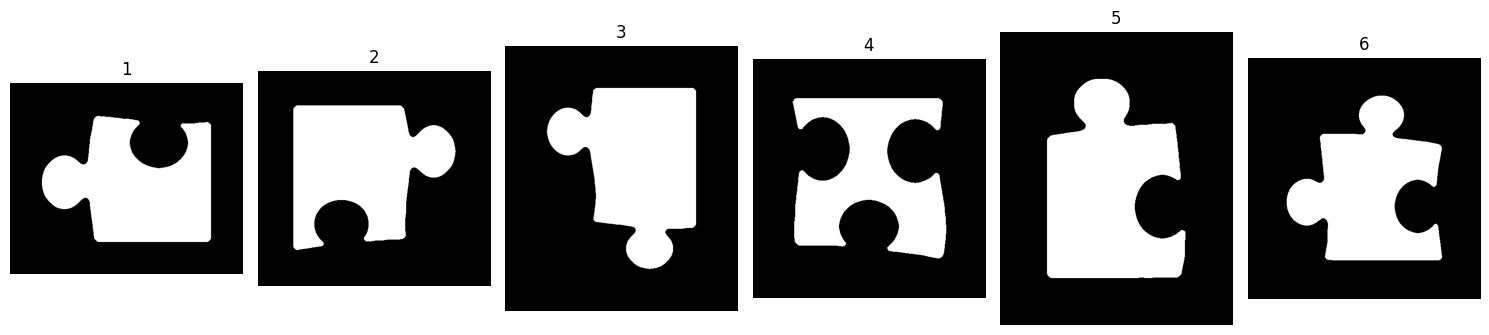

In [386]:
fig, axes = plt.subplots(nrows=1, ncols=len(universal_pieces), figsize=(15, 5))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_bw
    pad_len = (int)(len(image)/5)
    pieces_smoothed = cv2.copyMakeBorder(image, pad_len, pad_len, pad_len, pad_len, cv2.BORDER_CONSTANT, value=0)
    (universal_pieces[i]).piece_image_color = cv2.copyMakeBorder((universal_pieces[i]).piece_image_color, pad_len, pad_len, pad_len, pad_len, cv2.BORDER_CONSTANT, value=0)
    pieces_smoothed = cv2.medianBlur(pieces_smoothed,15)
    (universal_pieces[i]).piece_image_bw = pieces_smoothed
    axes[i].imshow(pieces_smoothed, cmap='gray')
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()

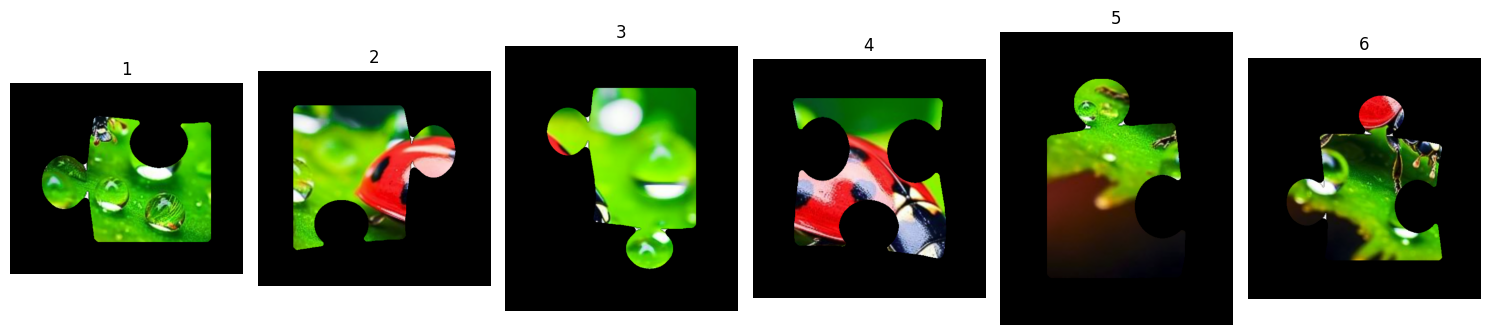

In [387]:
for i in range(len(universal_pieces)):
    cPiece = (universal_pieces[i]).piece_image_color
    bwPiece = (universal_pieces[i]).piece_image_bw
    new_cPiece = np.copy(cPiece)
    height, width = bwPiece.shape
    for j in range(height):
        for k in range(width):
            if bwPiece[j][k] == 0:
                new_cPiece[j][k] = (0,0,0)
            else:
                new_cPiece[j][k] = cPiece[j][k]
    (universal_pieces[i]).piece_image_color = new_cPiece

fig, axes = plt.subplots(nrows=1, ncols=len(universal_pieces), figsize=(15, 5))
# Iterate through the array and display each image
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_color
    axes[i].imshow(image)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(f"{i+1}")
# Adjust layout for better visualization
plt.tight_layout()
plt.show()


# Find corners

In [388]:
def find_rmse(X,Y,m, c, n):
    rmse = 0
    for i in range(n):
        a = m
        b = -1
        d = abs((a * X[i] + b * Y[i] + c)) / (math.sqrt(a * a + b * b))
        rmse += d
        # y_pred = c + m * X[i]
        # rmse += (Y[i] - y_pred) ** 2
    rmse =(rmse/n)
    return rmse

In [389]:
def find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half):
    # slope1, yinter1= np.polyfit(array_line1_x, array_line1_y, 1)
    # slope2, yinter2= np.polyfit(array_line2_x, array_line2_y, 1)
    line1reg = linregress(array_line1_x, array_line1_y)
    line2reg = linregress(array_line2_x, array_line2_y)
    slope1 = line1reg.slope
    slope2 = line2reg.slope
    yinter1 = line1reg.intercept
    yinter2 = line2reg.intercept
    PI = 3.14159265
    taninv = abs((slope2 - slope1) / (1 + slope1 * slope2))
    ret = math.atan(taninv)
    angle = (ret * 180) / PI
    val=0
    if(angle>50 and angle<130):
        val = 150
    else:
        val =0
    rsme = find_rmse(array_line1_x, array_line1_y, slope1, yinter1, half) +find_rmse(array_line2_x, array_line2_y, slope2, yinter2, half)
    # rsme = line1reg.stderr + line2reg.stderr
    if(rsme>(2)):
        val = 0
    return val, rsme

In [390]:
def find_biggestsquare(list_elements):
    big_area=0
    arr=[]
    comb = combinations(list_elements, 4)
    for i, j, k, l in list(comb):
        first = i[0]*j[1] + j[0]*k[1] + k[0]*l[1] + l[0]*i[1]
        second = j[0]*i[1] + k[0]*j[1] + l[0]*k[1] + i[0]*l[1]
        area = 0.5*(first - second)
        area = abs(area)
        if(area>big_area):
            big_area = area
            arr.clear()
            arr.append(i)
            arr.append(j)
            arr.append(k)
            arr.append(l)
    
    return arr
                        

In [391]:
def add_elem(xval, yval,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half):
    array_line2_x[pointer_line2] = xval
    array_line2_y[pointer_line2] = yval
    pointer_line2 = (pointer_line2+1)%half
    array_line2_x[pointer_line2] = array_line2_x[pointer_line2]+0.001
    array_line1_x[pointer_line1] = array_line2_x[pointer_line2]
    array_line1_y[pointer_line1] = array_line2_y[pointer_line2]
    pointer_line1 = (pointer_line1+1)%half
    array_line1_x[pointer_line1] = array_line1_x[pointer_line1]+0.001
    return pointer_line1, pointer_line2

In [392]:
def find_corners(find_corner_image):
    completed = False
    pieces_drawbound = np.copy(find_corner_image)

    i=0
    j=0

    while(pieces_drawbound[i+1][j+1]!=255):
        i=i+1
        j=j+1

    # pieces_drawbound[i][j] = 200
    # show_gray(pieces_drawbound,"")
    
    size = len(pieces_drawbound)/4

    half = (int)((size+1)/2)
    array_line1_x = [0 for element in range(half)]
    array_line1_y = [0 for element in range(half)]
    pointer_line1 = 0
    array_line2_x = [1 for element in range(half)]
    array_line2_y = [1 for element in range(half)]
    pointer_line2 = 0

    list_elements = []

    direction =0 #0 is up, 1 is right, 2 is down and 3 is left
    move = [[-1,0],[0,1],[1,0],[0,-1]]
    initial_i = i
    initial_j = j
    counter = 0
    counter_add = 0
    while (not(completed) and counter<5000):
        counter= counter+1
        index = direction
        top_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        index = index +1
        right_piece = pieces_drawbound[i+move[index%4][0]][j+move[index%4][1]]
        if(right_piece==255):
            if(top_piece==255):
                direction = direction-1
            else:
                pointer_line1,pointer_line2 = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half)
                counter_add = counter_add+1

                if(counter_add==(half-1)):
                    initial_i = i
                    initial_j = j
            
                
                if(counter_add>=size):
                    val, rsme = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                    if(val>0):
                        list_elements.append([int(array_line2_x[pointer_line2]),int(array_line2_y[pointer_line2]), rsme])
                    # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                    if(int(array_line2_x[pointer_line2])==initial_i and int(array_line2_y[pointer_line2])==initial_j):
                        completed = True

                

                i = i+move[direction%4][0]
                j = j+move[direction%4][1]
        else:
            pointer_line1,pointer_line2 = add_elem(i,j,array_line1_x, array_line1_y, pointer_line1, array_line2_x, array_line2_y, pointer_line2, half)
            
            counter_add = counter_add+1
        
            if(counter_add==(half-1)):
                initial_i = i
                initial_j = j

            if(counter_add>=size):
                val, rmse = find_angle(array_line1_x, array_line1_y,array_line2_x, array_line2_y, half)
                if(val>0):
                    list_elements.append([int(array_line2_x[pointer_line2]),int(array_line2_y[pointer_line2]), rmse])
                # pieces_drawbound[array_line2_x[pointer_line2]][array_line2_y[pointer_line2]] = val
                if(int(array_line2_x[pointer_line2])==initial_i and int(array_line2_y[pointer_line2])==initial_j):
                    completed = True


            direction = direction+1
            i = i+move[direction%4][0]
            j = j+move[direction%4][1]
    # final = find_biggestsquare(list_elements)

    final_list = []
    local_min = list_elements[0][2]
    local_x = list_elements[0][0]
    local_y = list_elements[0][1]
    # final_list = list_elements
    for i in range(1,len(list_elements)):
        # print(list_elements[i])
        x = list_elements[i][0]
        y = list_elements[i][1]
        prev_x = list_elements[i-1][0]
        prev_y = list_elements[i-1][1]
        if((x>prev_x-2 and x<prev_x+2) and (y>prev_y-2 and y<prev_y+2)):
            if(list_elements[i][2]<local_min):
                local_min = list_elements[i][2]
                local_x = x
                local_y = y
        else:
            final_list.append([local_x, local_y, local_min])
            # print("hi")
            local_min = list_elements[i][2]
            local_x = x
            local_y = y
    final_list.append([local_x, local_y, local_min])

    final = find_biggestsquare(final_list)

    for i in final:
        cv2.circle(pieces_drawbound, (int(i[1]) , int(i[0])), 2, (200),2)
        # pieces_drawbound[int(i[0])][int(i[1])]=150


    # for i in final:
        # pieces_drawbound[i[0]][i[1]]=150
    return pieces_drawbound, [(i[0], i[1]) for i in final]


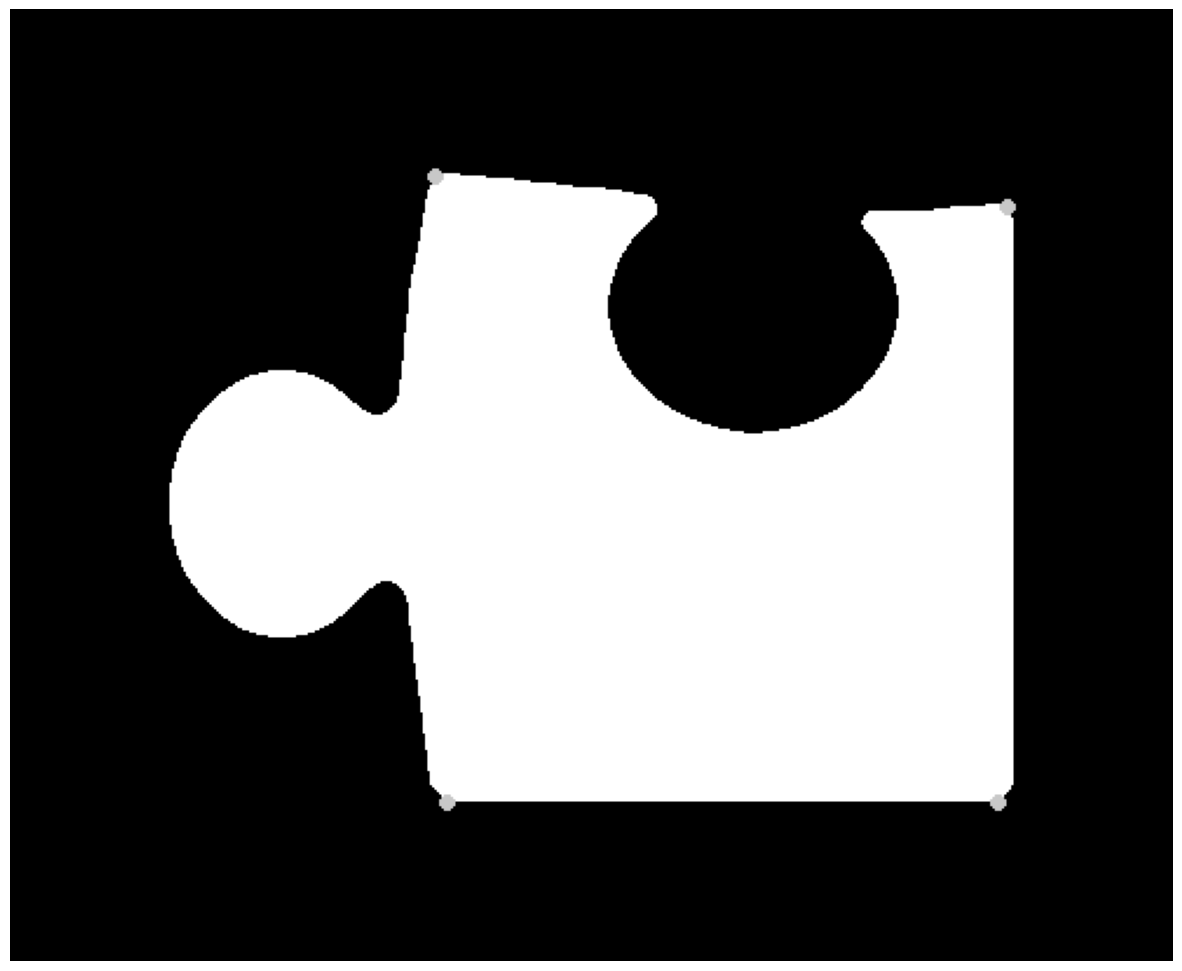

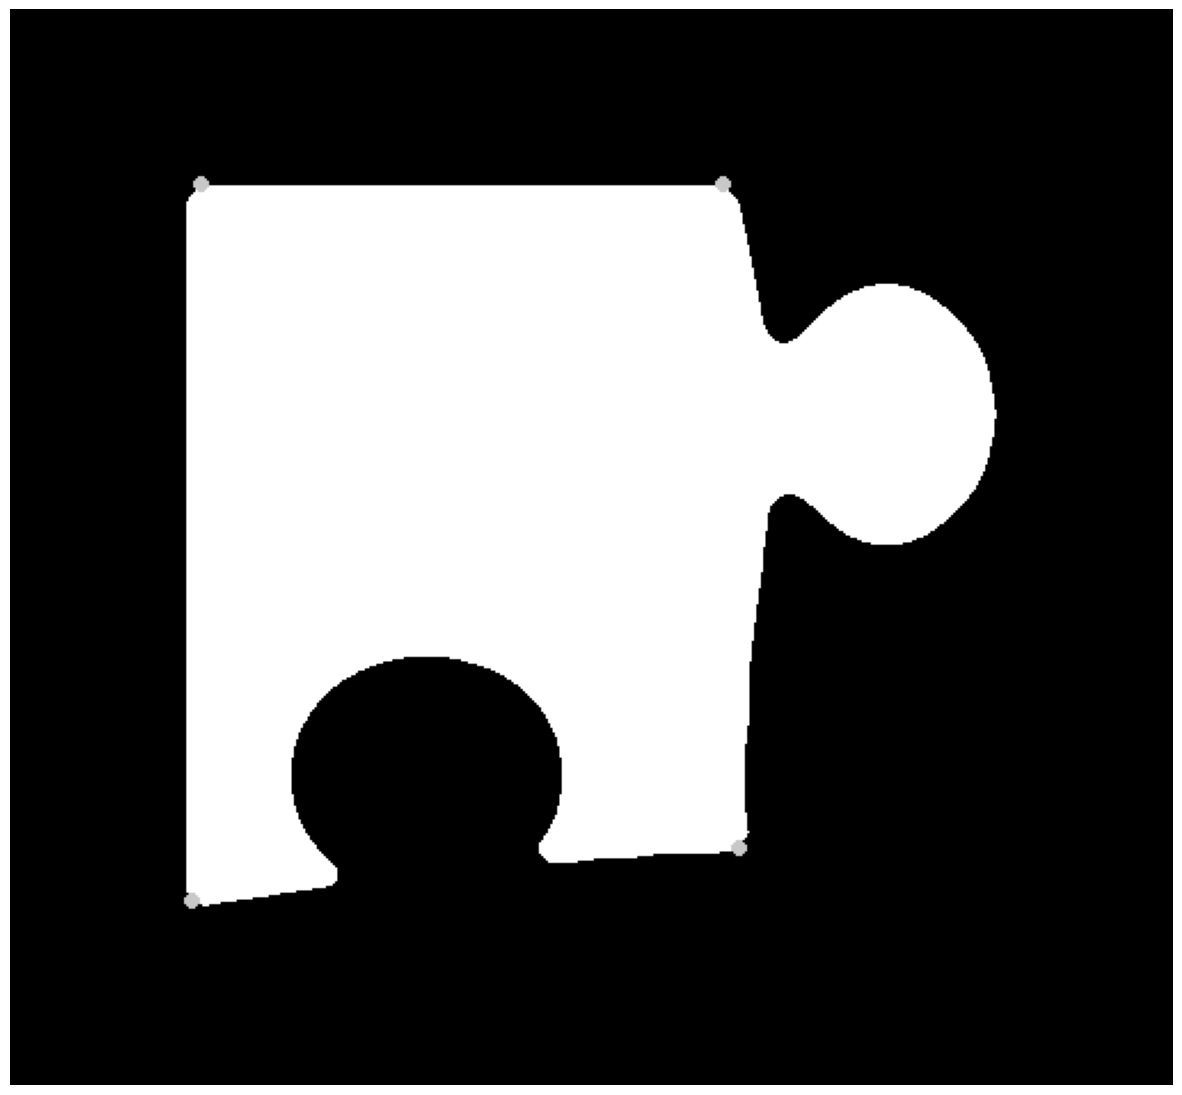

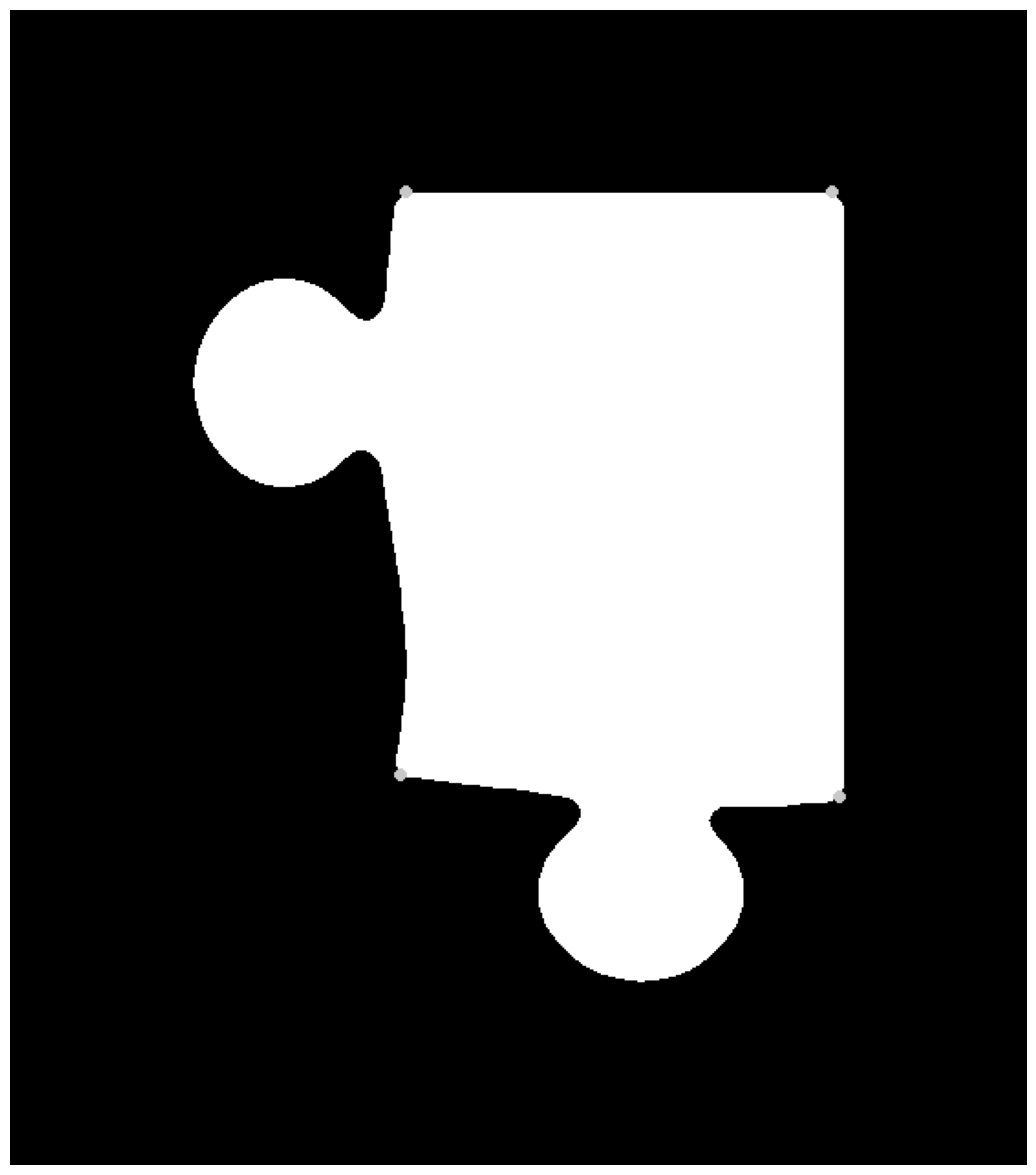

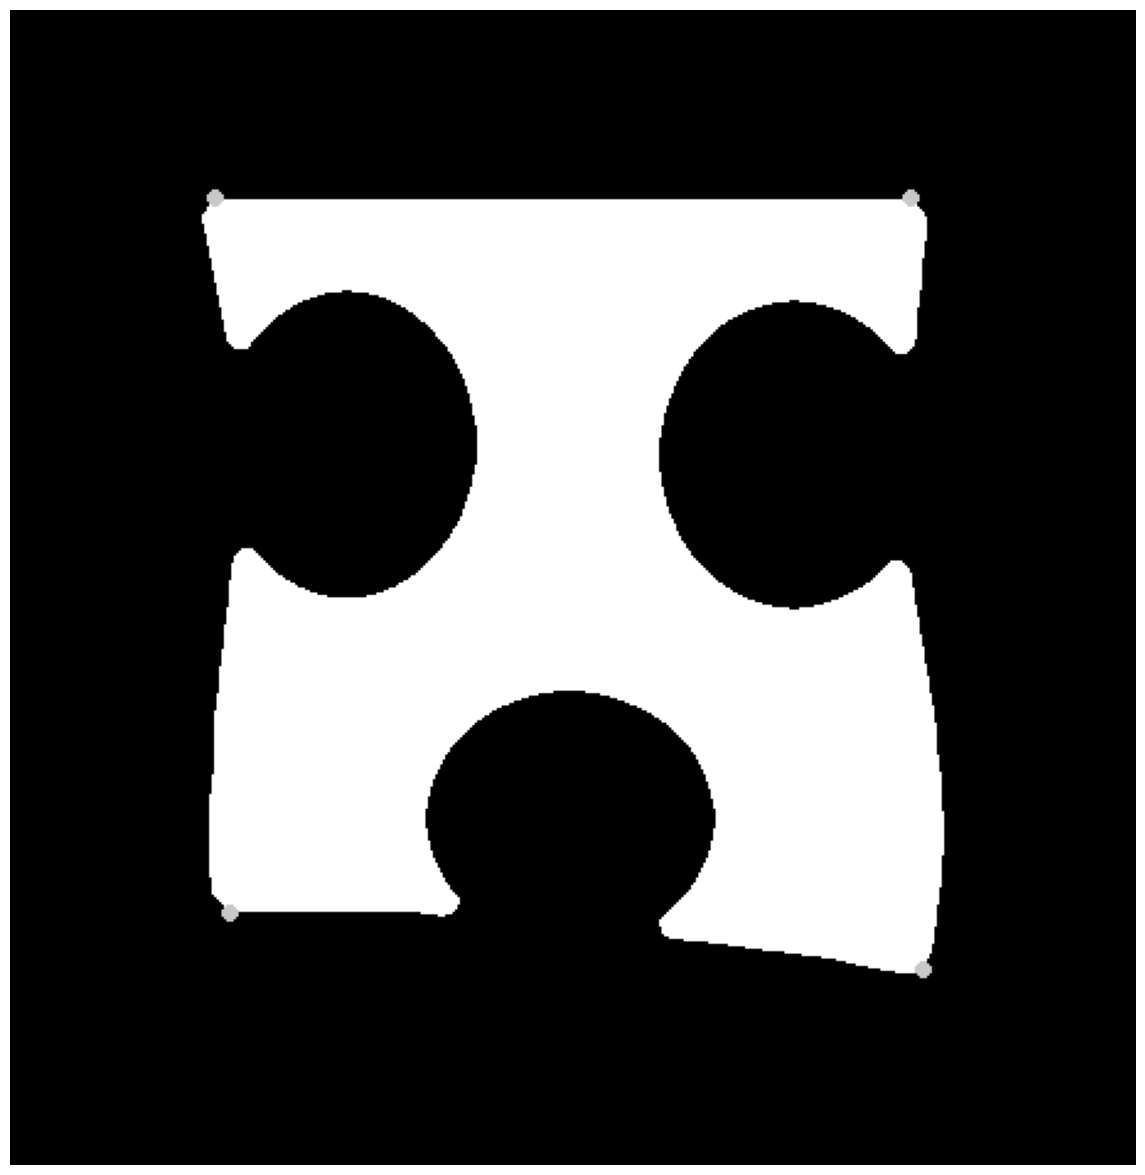

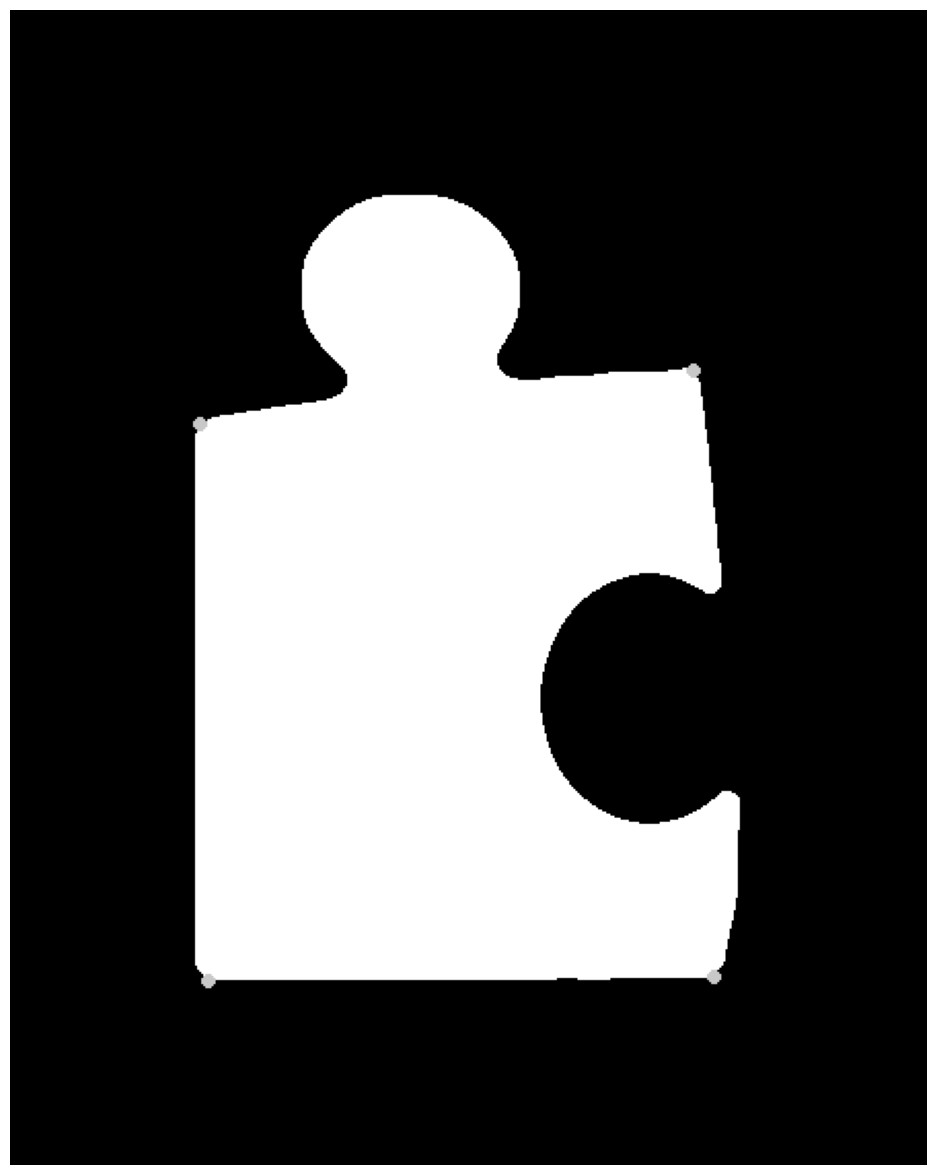

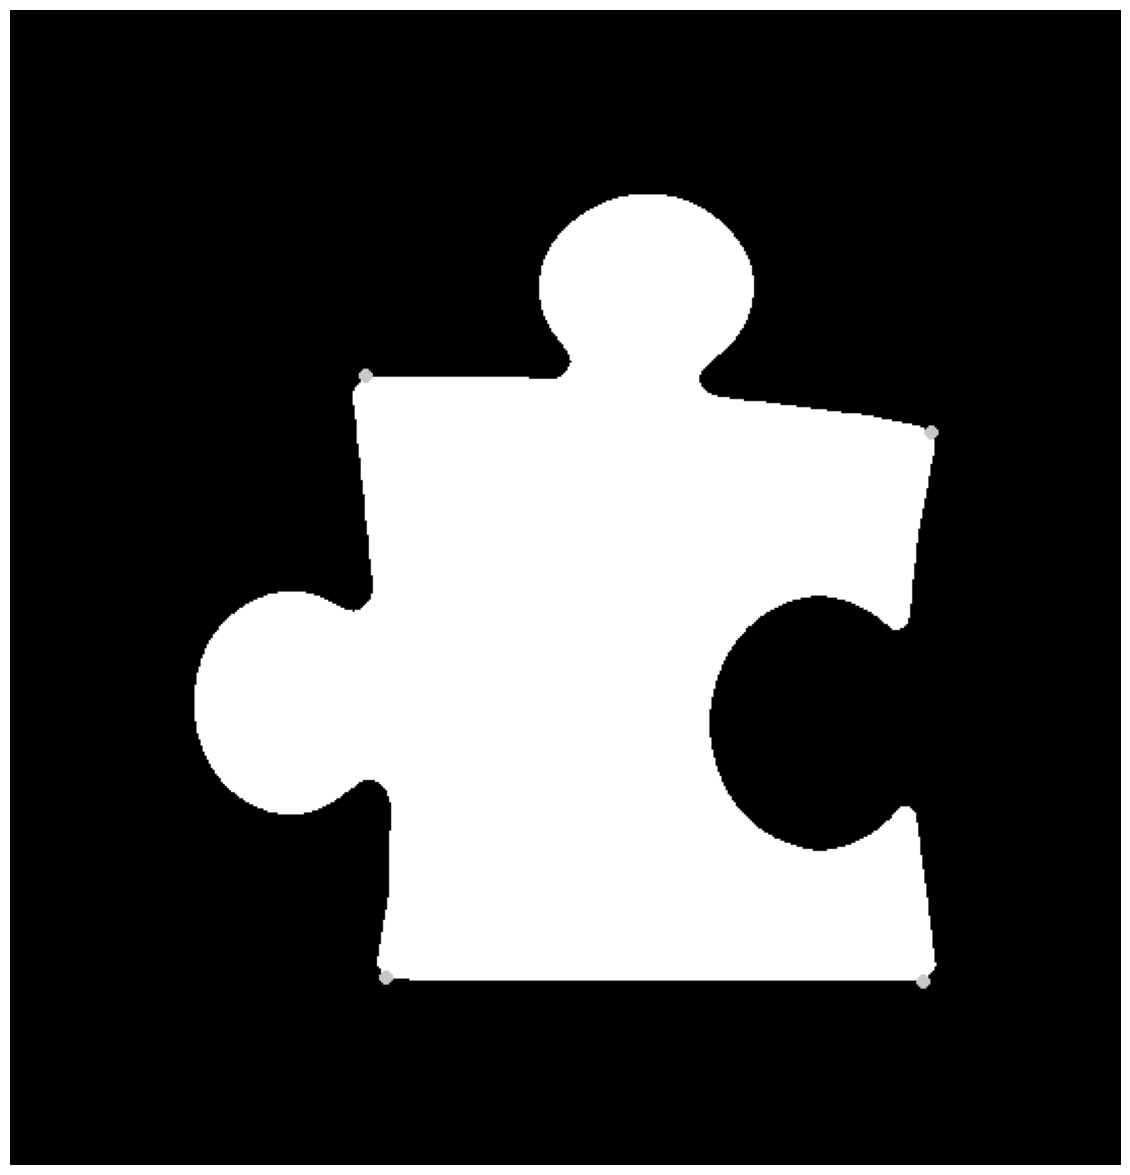

In [393]:
for i in range(len(universal_pieces)):
    image = (universal_pieces[i]).piece_image_bw
    piece_with_corner, corners = find_corners(image)
    (universal_pieces[i]).corners  = corners
    show_gray(piece_with_corner,"")

# Get Edge Images

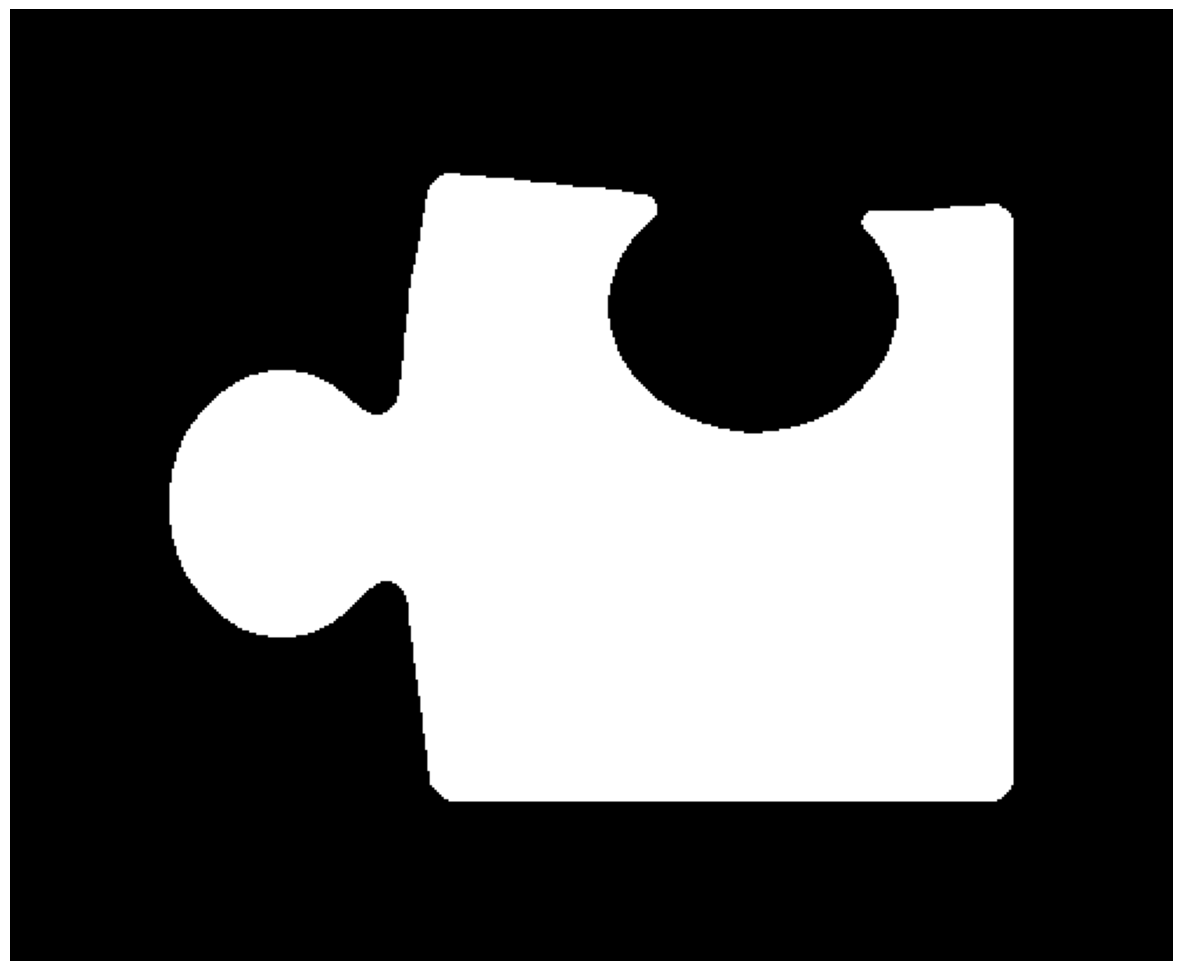

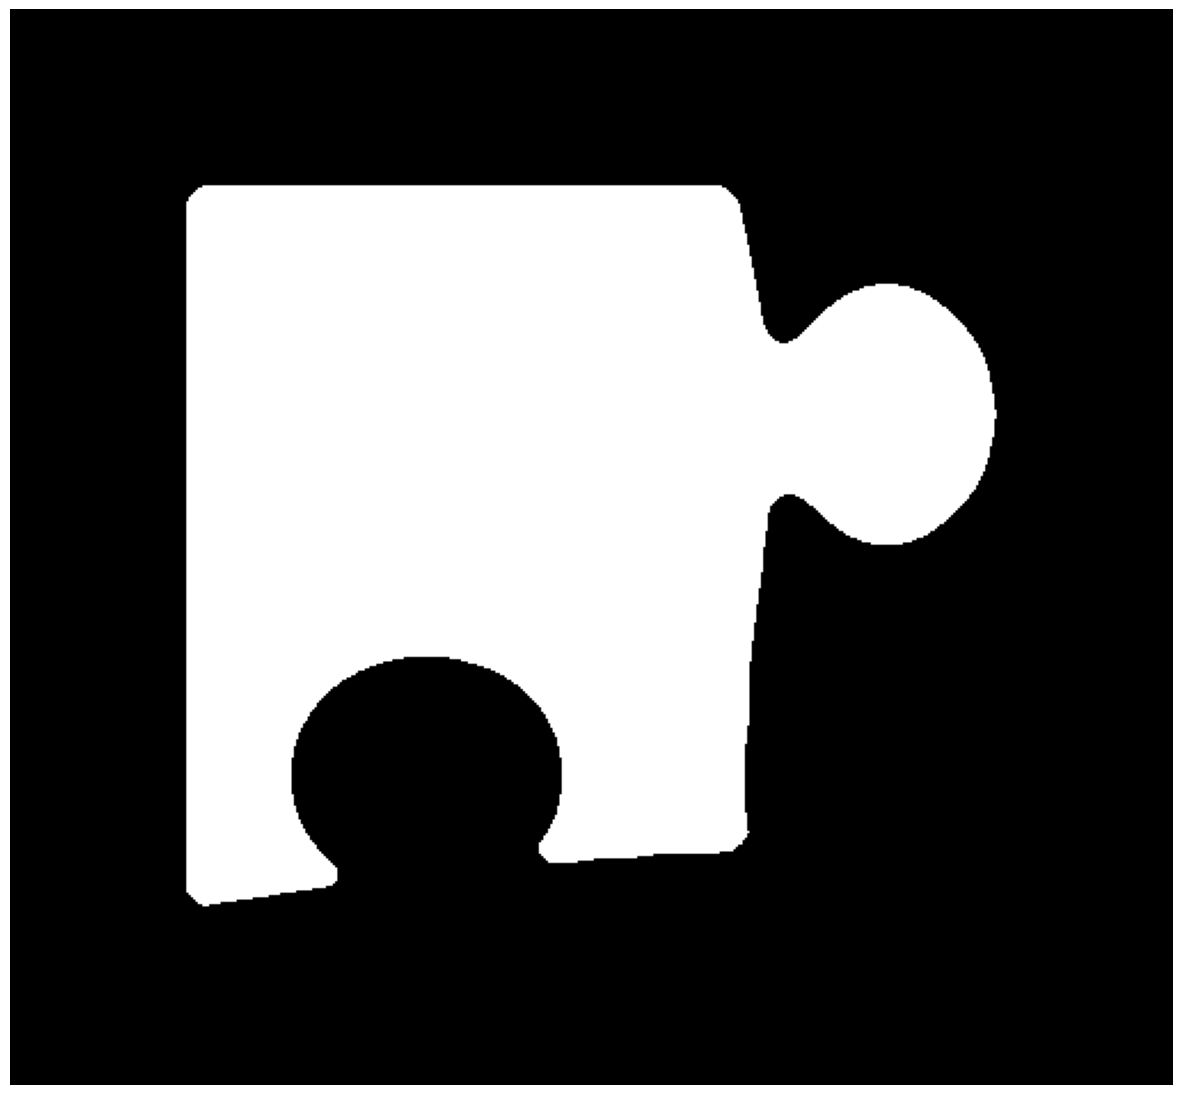

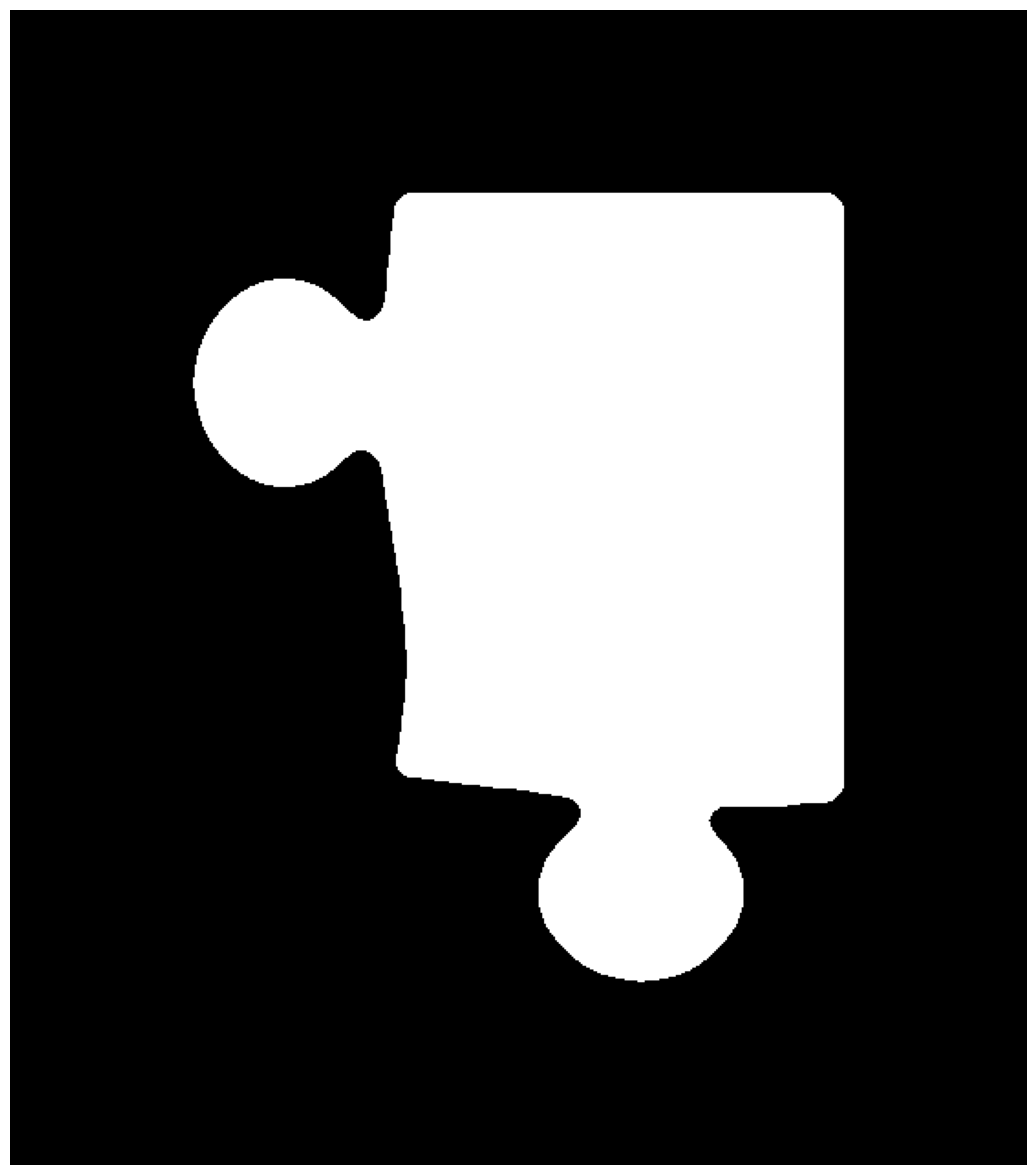

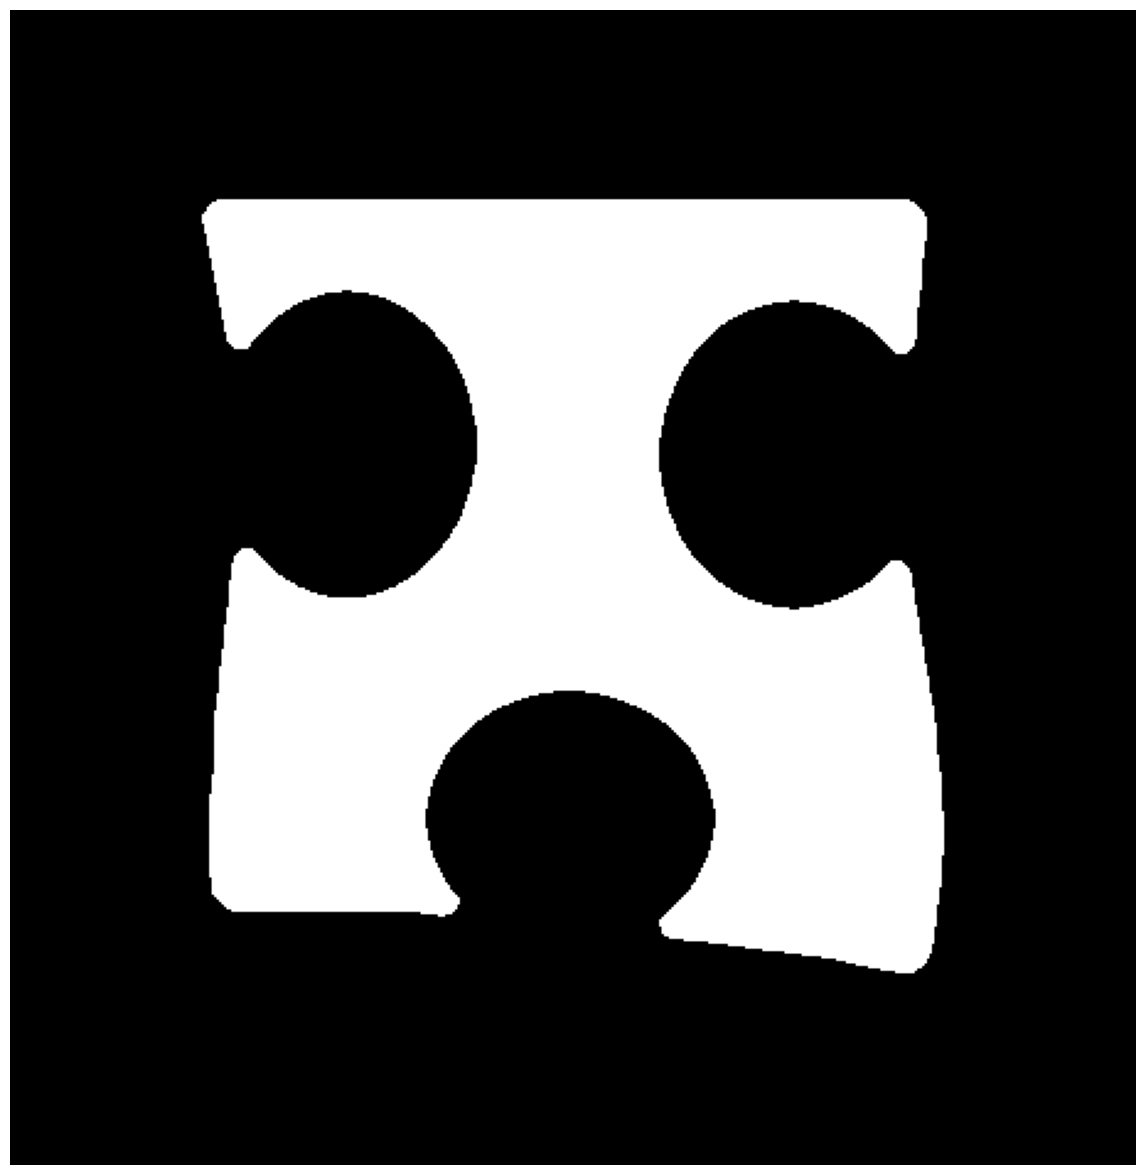

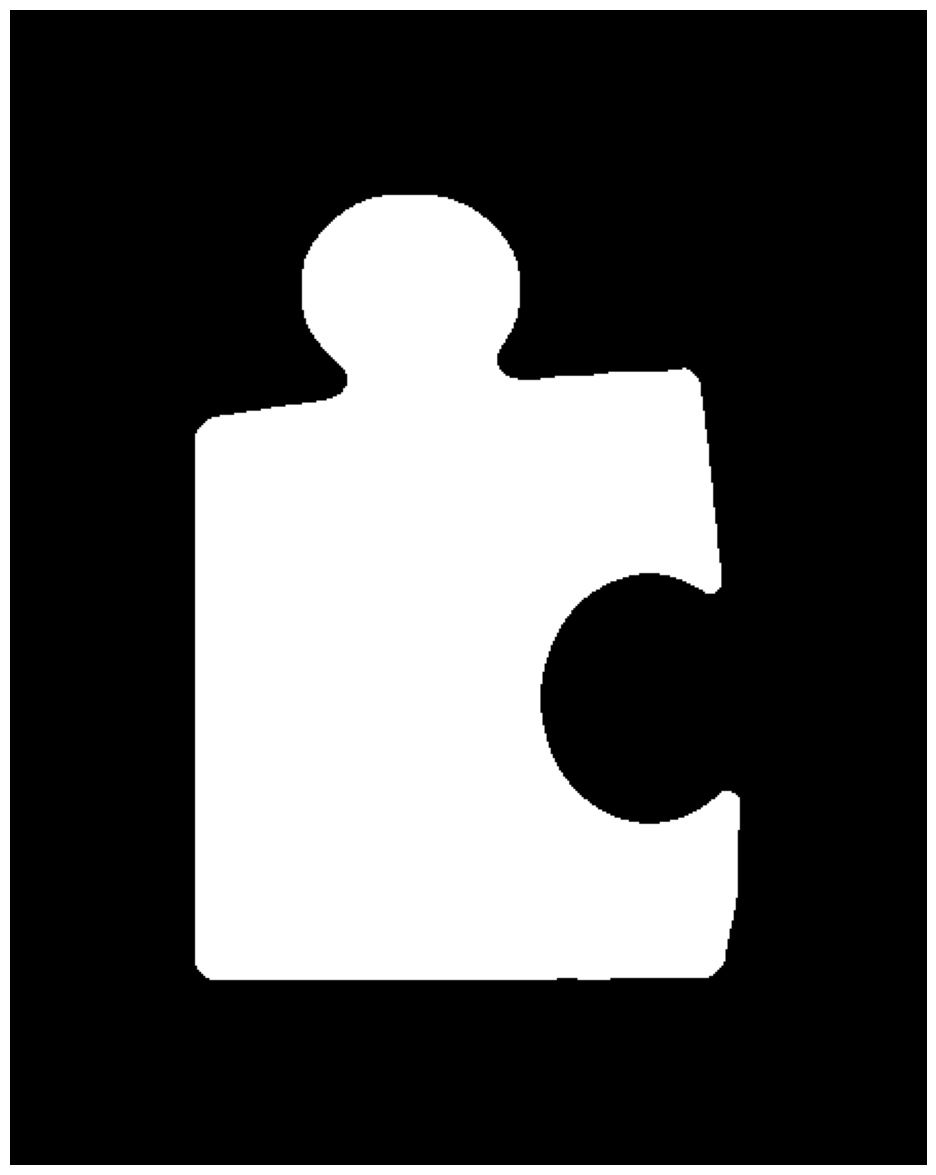

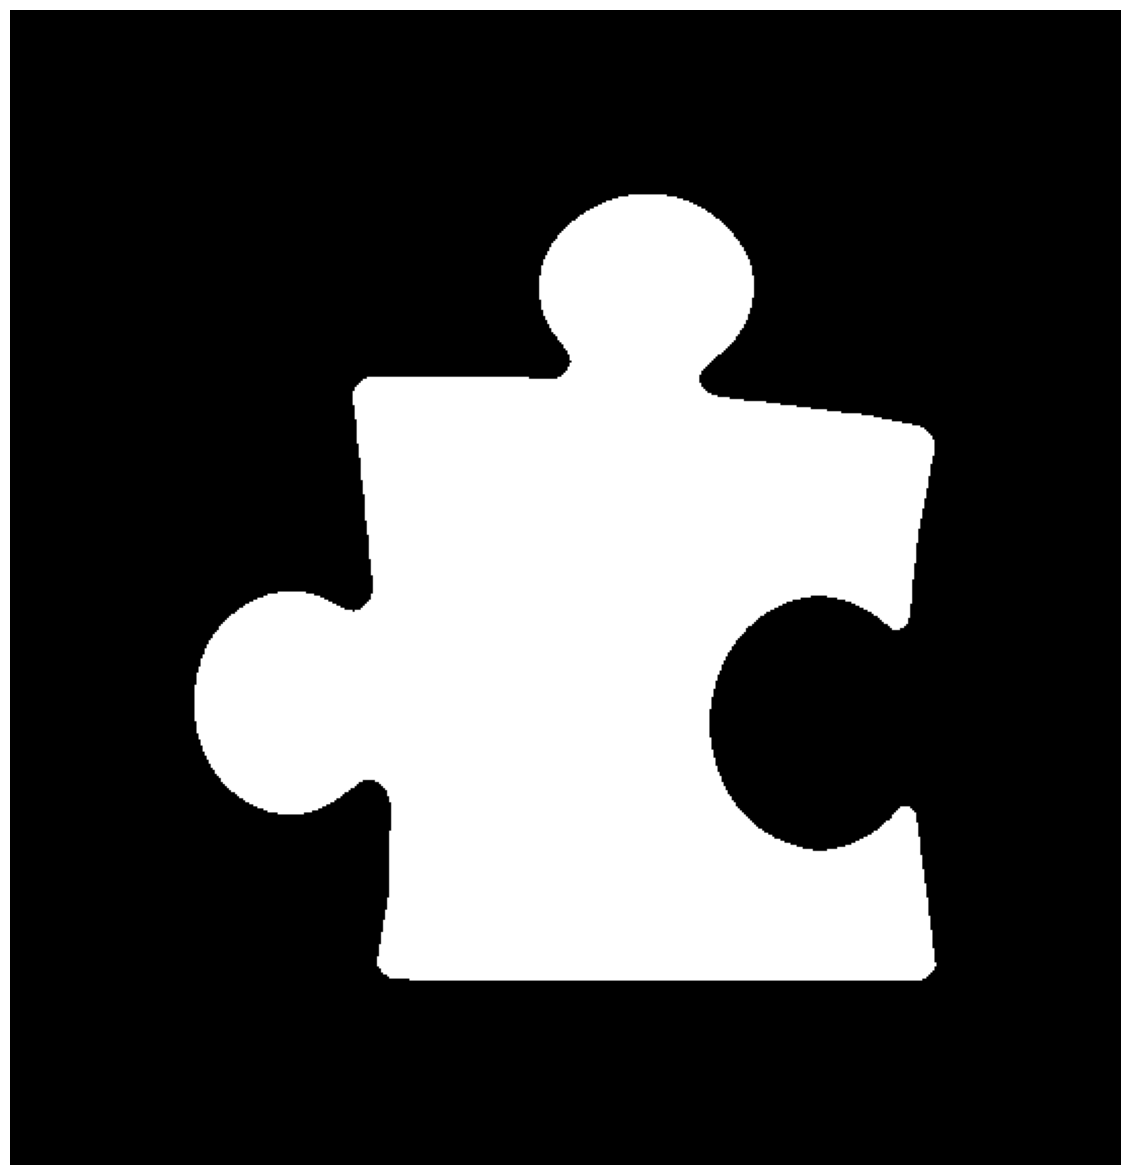

In [403]:
def get_slope_intercept(p1, p2, p3):
    slope = 0
    if(p1[1] != p2[1]):
        slope = (p1[0] - p2[0]) / (p1[1] - p2[1])
    else:
        slope = 999
    intercept = p3[1] - slope*p3[0]
    return [slope, intercept]

pieces_side_points = []
colored_pieces_side_points = []
pieces_corner_dist = []

for ind in range(len(universal_pieces)):
    puzzle = (universal_pieces[ind]).corners
    sides = []
    sides_dist = []
    x_avg = sum([j[1] for j in puzzle])/4
    y_avg = sum([j[0] for j in puzzle])/4
    for i in range(4):
        x_mid = (puzzle[i][1] + puzzle[(i+1)%4][1])/2
        y_mid = (puzzle[i][0] + puzzle[(i+1)%4][0])/2
        slope_intercept = get_slope_intercept(puzzle[i], puzzle[(i+1)%4], (x_mid, y_mid))
        inner_line_slope_intercept = [slope_intercept[0], y_avg - slope_intercept[0]*x_avg]
        pieces_corner_drawn = (universal_pieces[ind]).piece_image_bw
        heig, leng = pieces_corner_drawn.shape

        for x in range(leng):
            y = int(slope_intercept[0] * x + slope_intercept[1])
            while 0 <= y < heig:
                if pieces_corner_drawn[y][x] == 255:
                    if(slope_intercept[1] > inner_line_slope_intercept[1]):
                        slope_intercept[1] += 1
                    else:
                        slope_intercept[1] -= 1
                else: break
                y = int(slope_intercept[0] * x + slope_intercept[1])

        if(slope_intercept[0] != 0):
            for y in range(heig):
                x = int(((y-slope_intercept[1]) / slope_intercept[0]))
                while 0 <= x < leng:
                    if pieces_corner_drawn[y][x] == 255:
                        if(slope_intercept[1] > inner_line_slope_intercept[1]):
                            slope_intercept[1] += 1
                        else:
                            slope_intercept[1] -= 1
                    else: break
                    x = int(((y-slope_intercept[1]) / slope_intercept[0]))

        orthogonal_slope = -1/slope_intercept[0] if slope_intercept[0] != 0 else 999
        
        top_left_orthogonal_intercept = puzzle[i][0] - orthogonal_slope*puzzle[i][1]
        top_left_x = (top_left_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_left_y = orthogonal_slope*top_left_x + top_left_orthogonal_intercept
        bottom_left_x = (top_left_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_left_y = orthogonal_slope * bottom_left_x + top_left_orthogonal_intercept 
        top_right_orthogonal_intercept = puzzle[(i+1)%4][0] - orthogonal_slope*puzzle[(i+1)%4][1]
        top_right_x = (top_right_orthogonal_intercept - slope_intercept[1])/(slope_intercept[0]-orthogonal_slope)
        top_right_y = orthogonal_slope * top_right_x + top_right_orthogonal_intercept 
        bottom_right_x = (top_right_orthogonal_intercept - inner_line_slope_intercept[1])/(inner_line_slope_intercept[0]-orthogonal_slope)
        bottom_right_y = orthogonal_slope * bottom_right_x + top_right_orthogonal_intercept 

        left_corner_dist = np.round(math.dist((top_left_y, top_left_x), puzzle[i]))
        right_corner_dist = np.round(math.dist((top_right_y, top_right_x), puzzle[(i+1)%4]))

        sides_dist.append((left_corner_dist+right_corner_dist)//2)
        #important part (x, y) where x is axis 1 and y is axis 0
        square = [(top_right_x, top_right_y), (bottom_right_x, bottom_right_y), (bottom_left_x, bottom_left_y), (top_left_x, top_left_y)]
        square = [(int(x), int(y)) for x, y in square]
        sides.append(square)
        def draw_line(image, slope, intercept, color=140, thickness=1):
            # Get image dimensions
            length, height= image.shape
            x1 = 0
            y1 = int(slope*x1 + intercept)
            x2 = int(height)
            y2 = int(slope*x2 + intercept)
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
        # draw_line(pieces_corner_drawn[ind], slope_intercept[0], slope_intercept[1])
        # draw_line(pieces_corner_drawn[ind], inner_line_slope_intercept[0], inner_line_slope_intercept[1])
    pieces_side_points.append(sides)
    pieces_corner_dist.append(sides_dist)
    show_gray(pieces_corner_drawn, "")
                

2.0
Hole


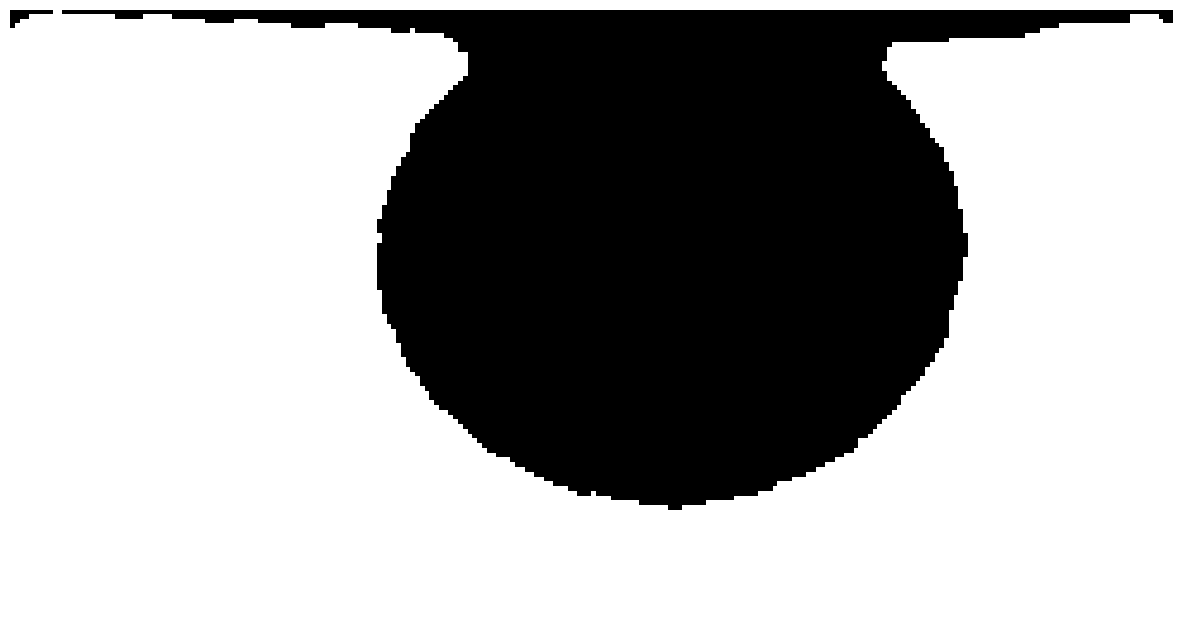

7.0
Flat


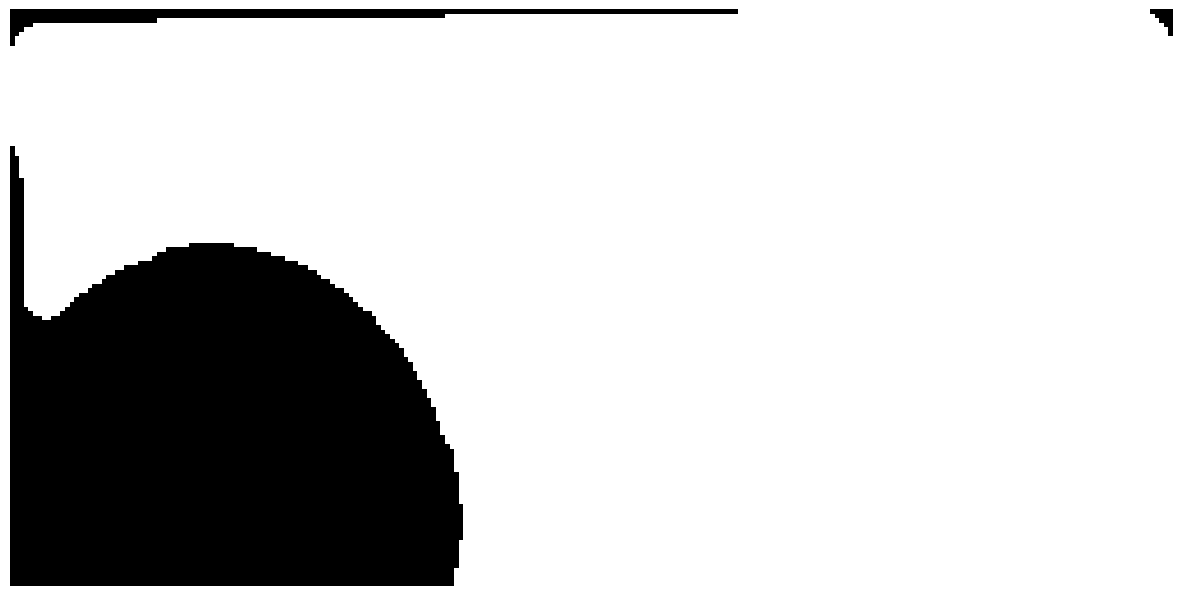

0.0
Flat


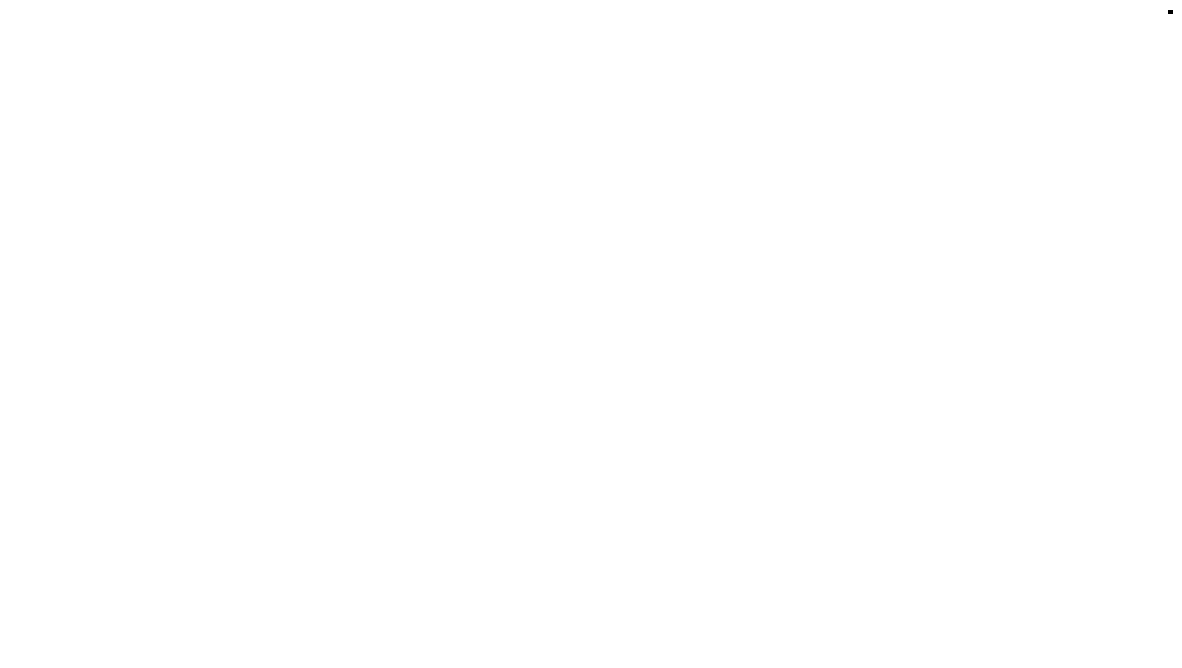

116.0
Head


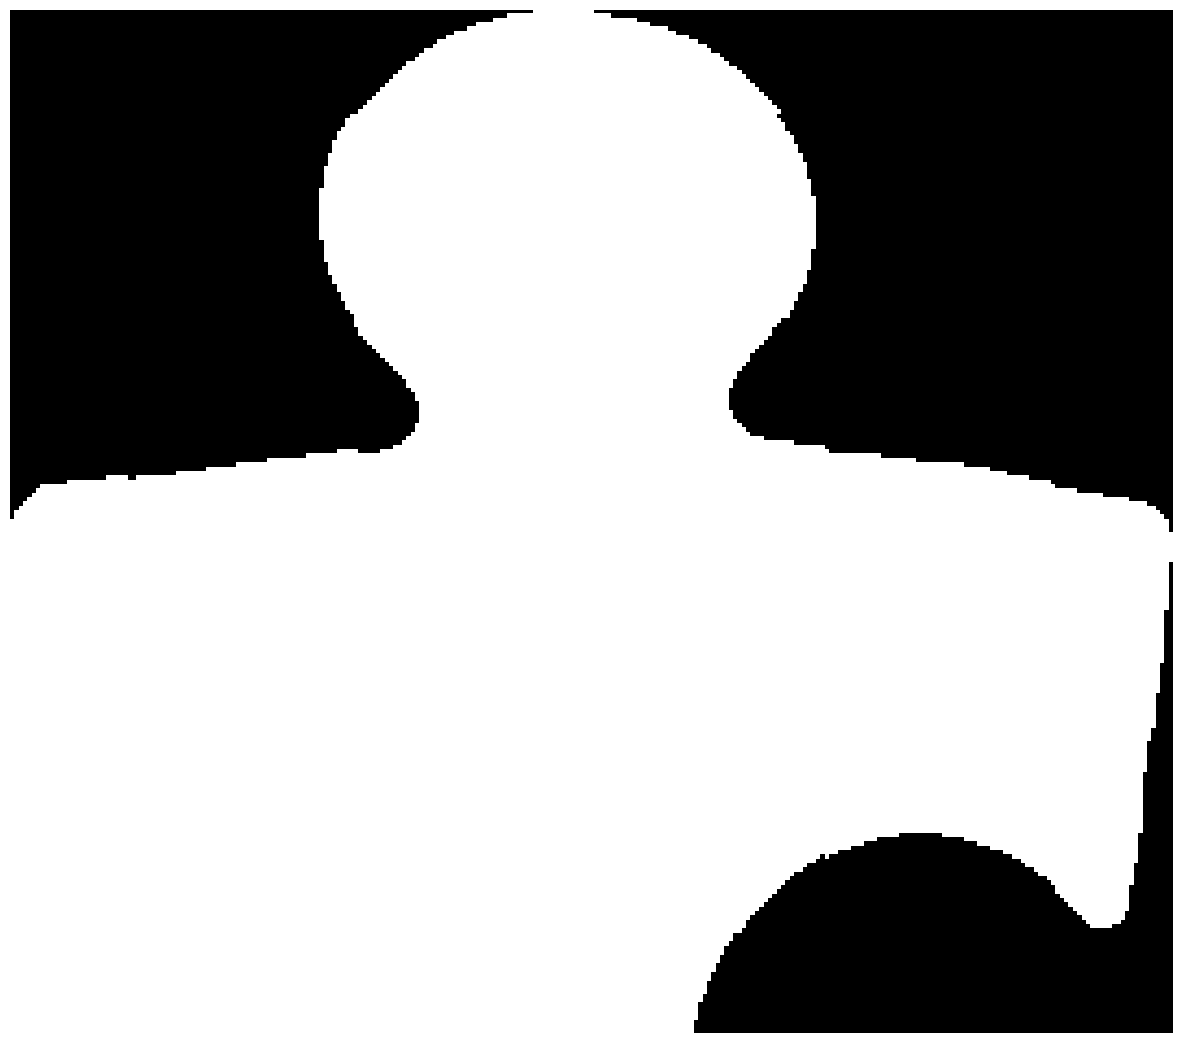

118.0
Head


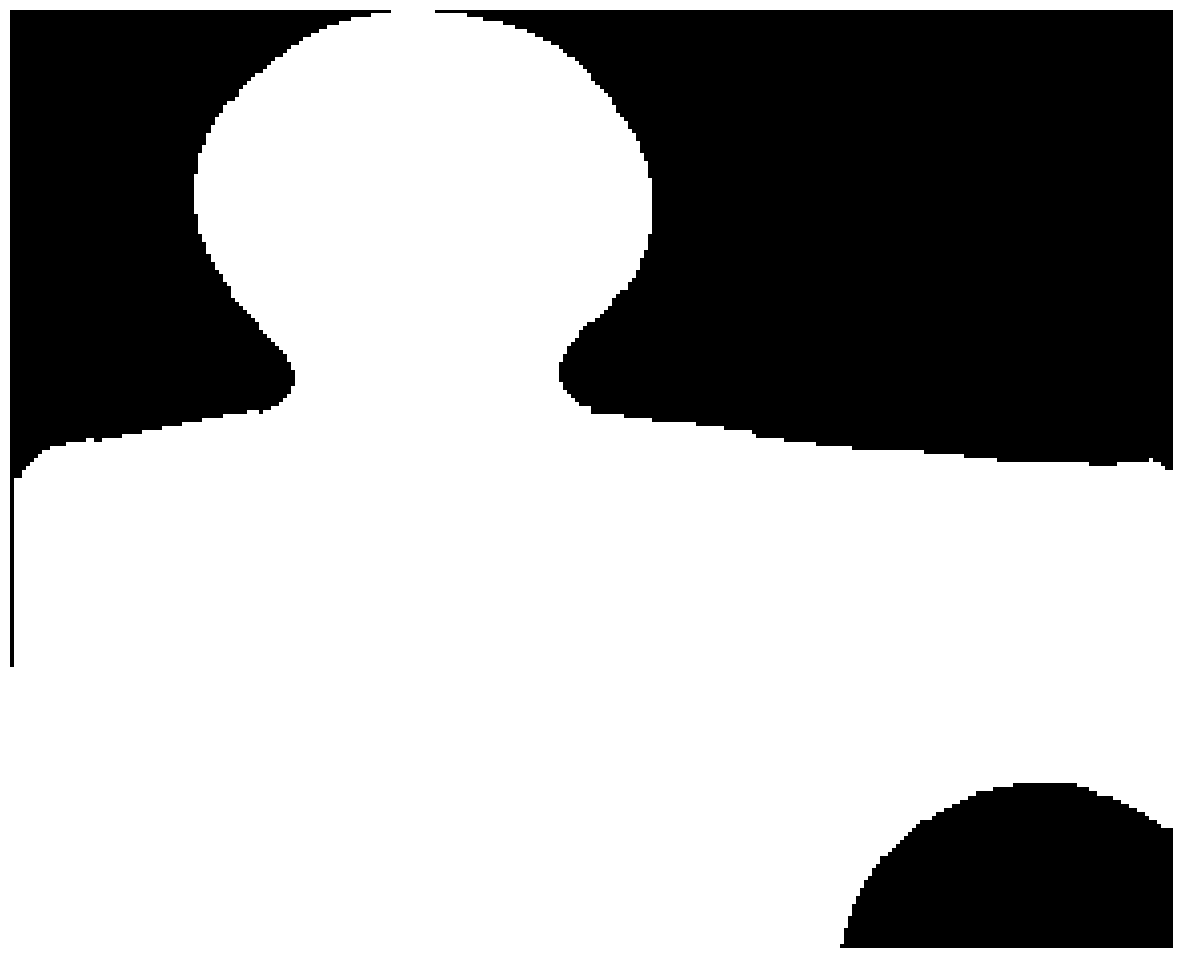

4.0
Hole


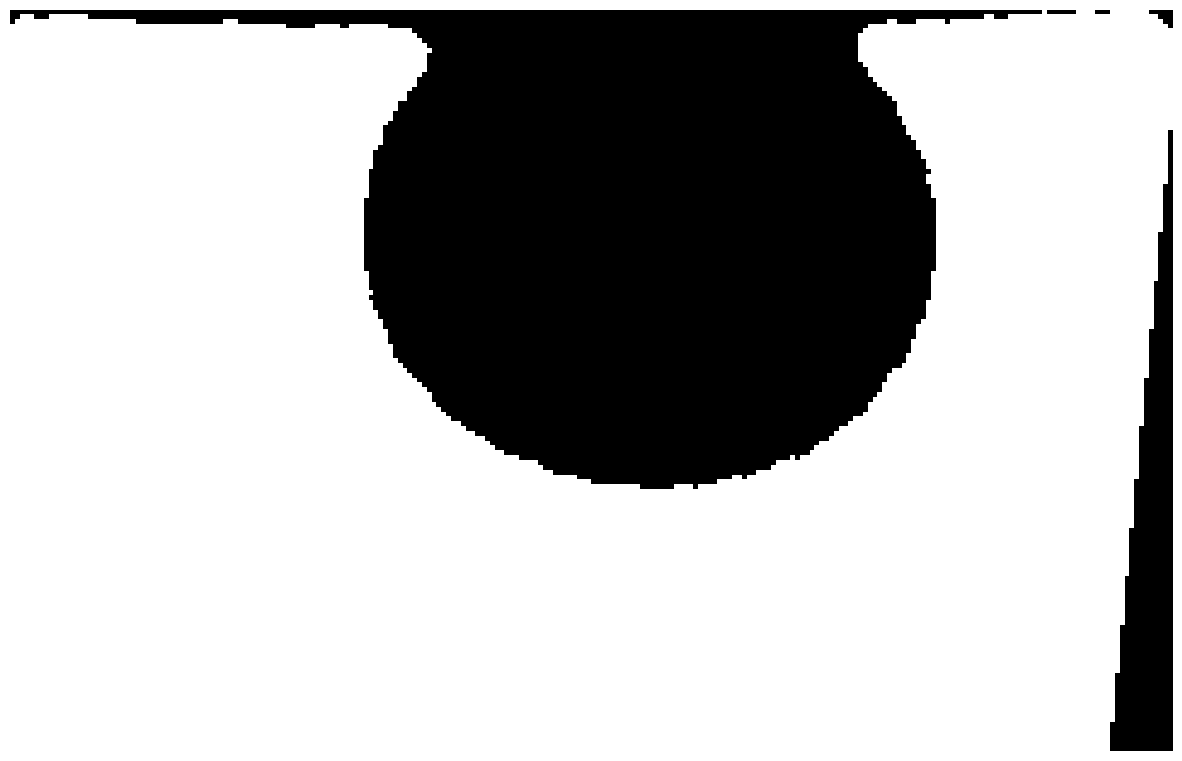

6.0
Flat


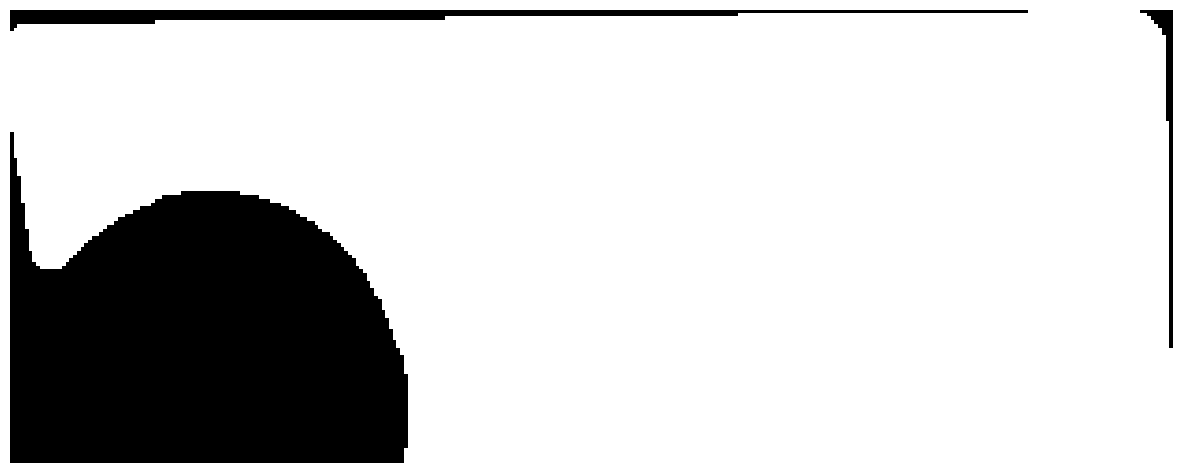

0.0
Flat


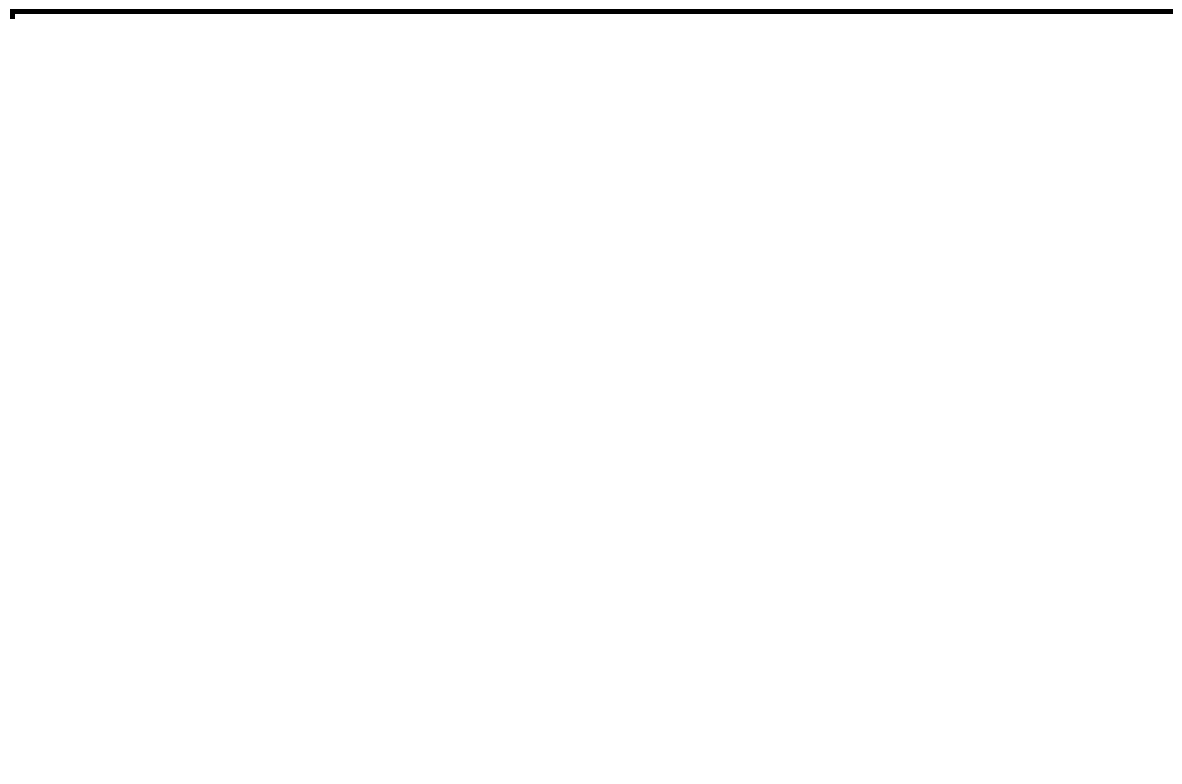

0.0
Flat


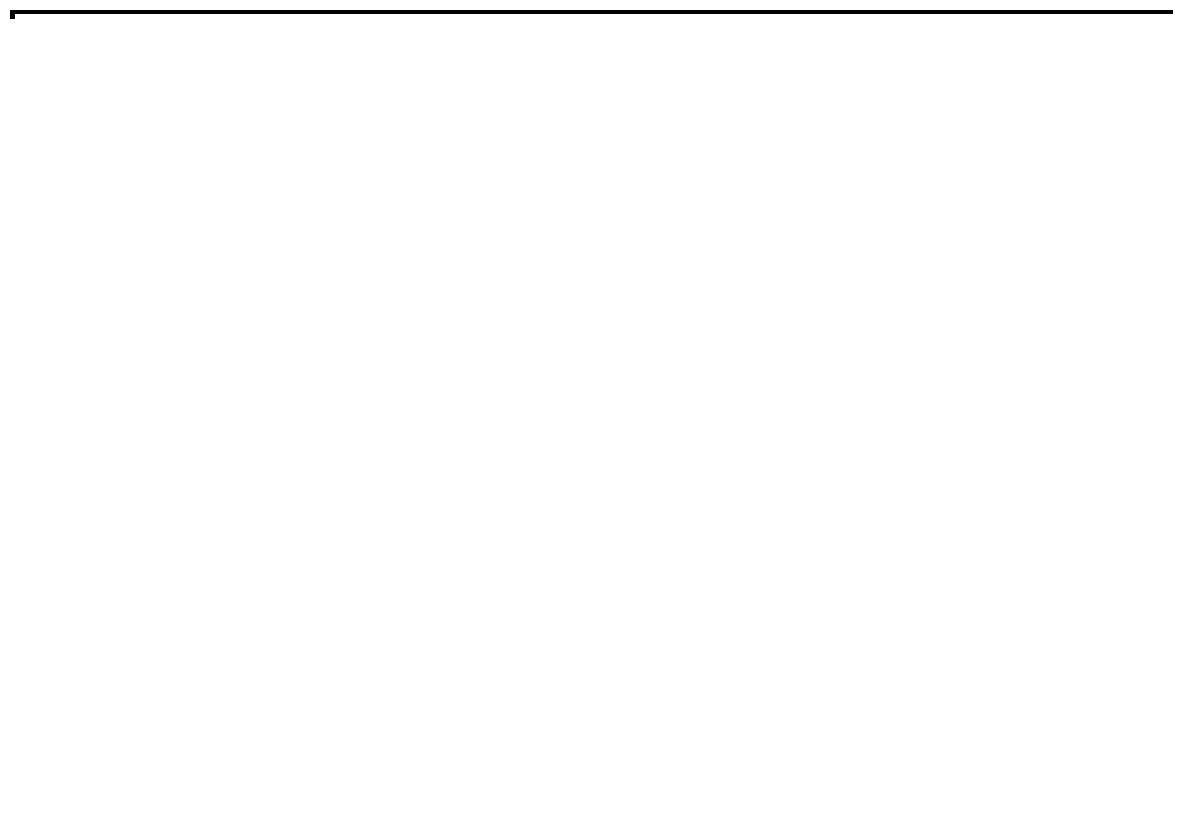

7.0
Flat


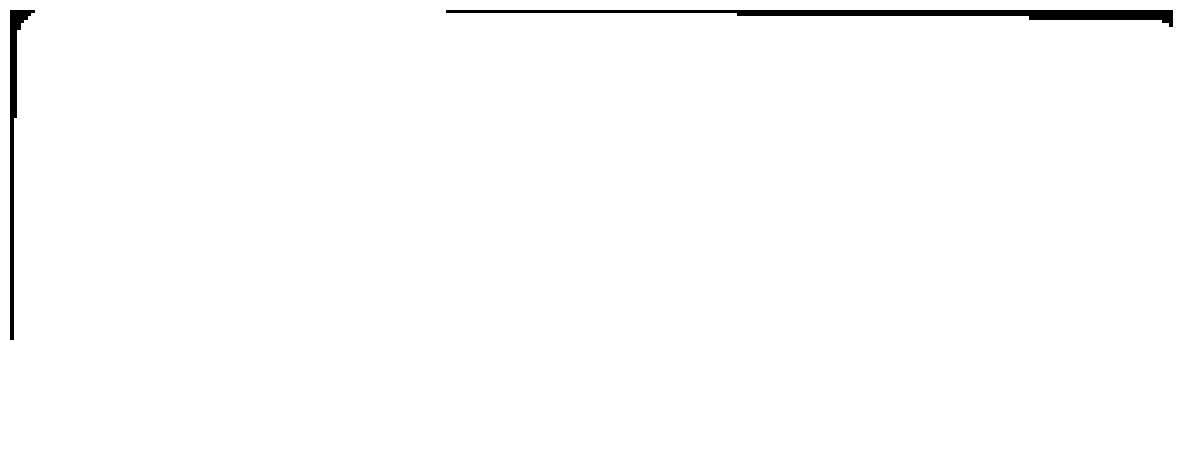

108.0
Head


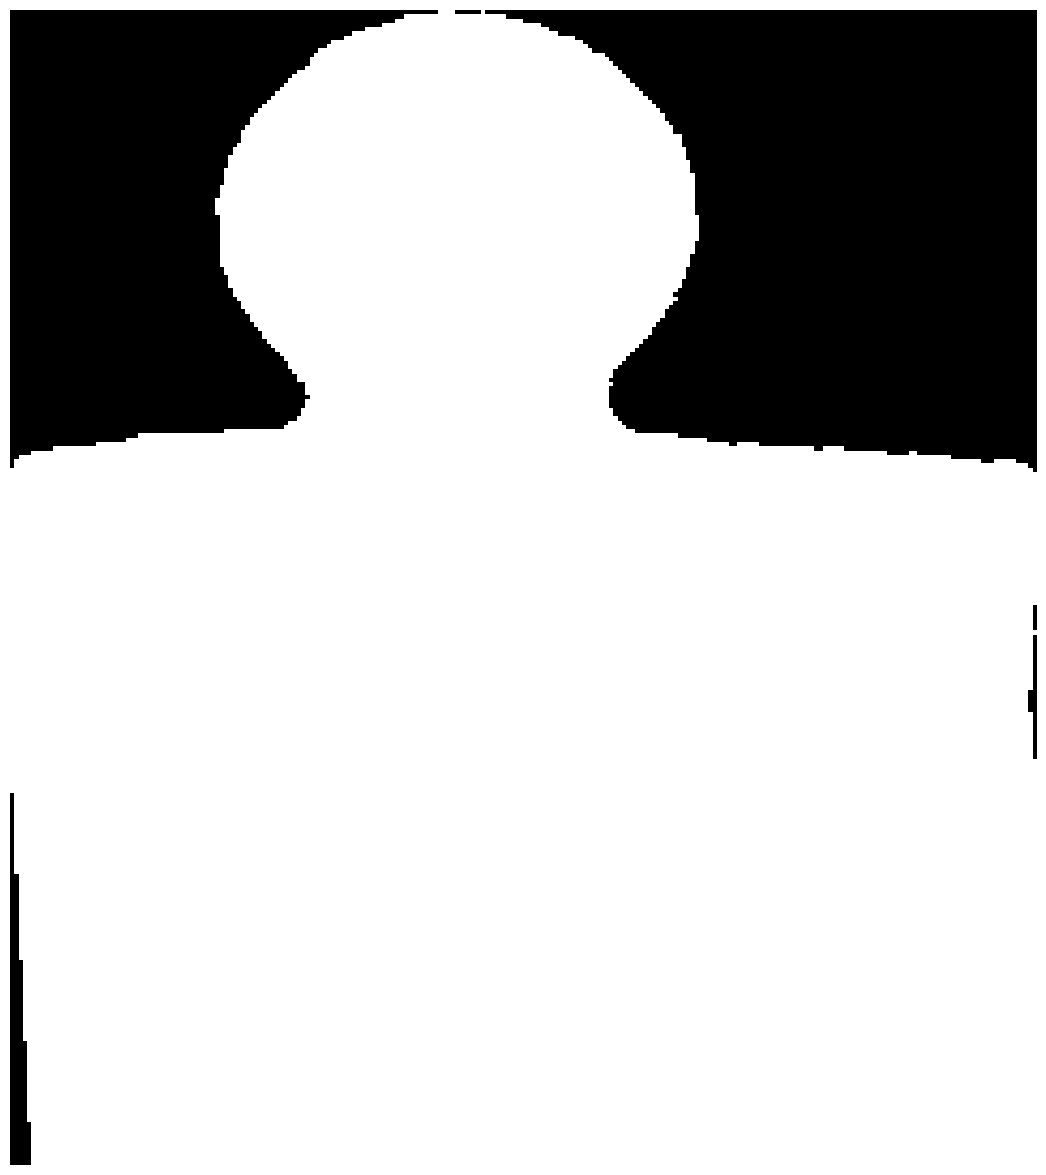

115.0
Head


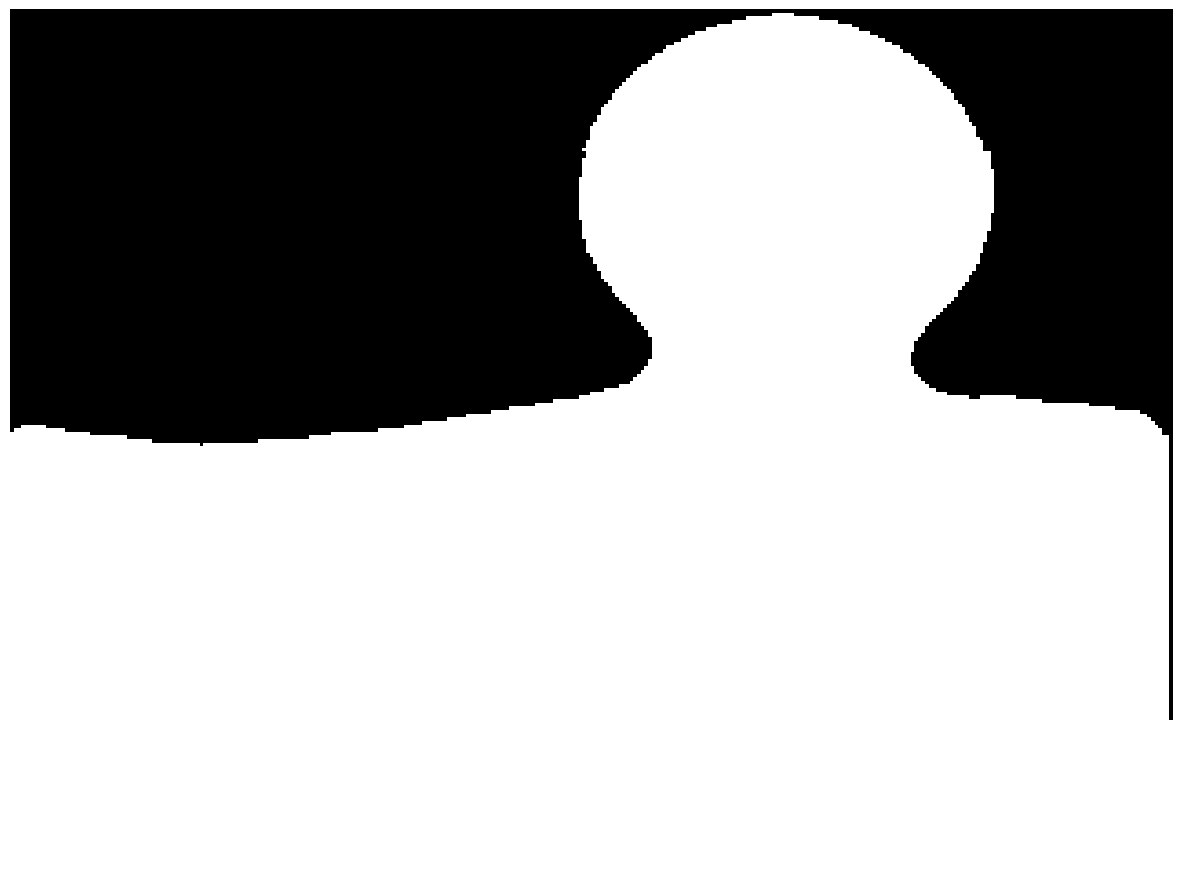

10.0
Hole


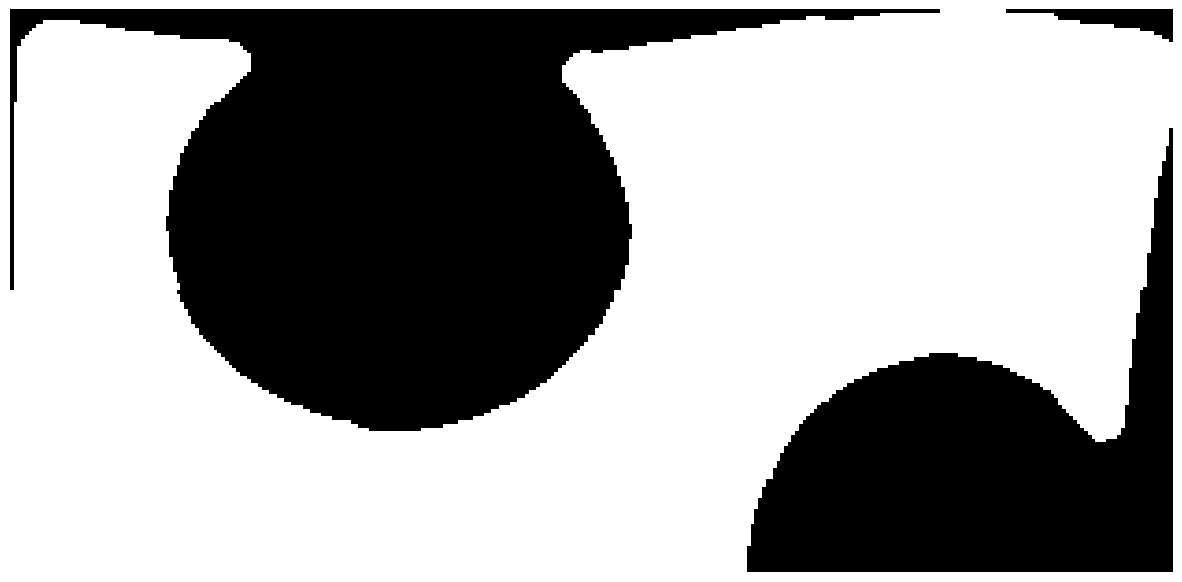

3.0
Hole


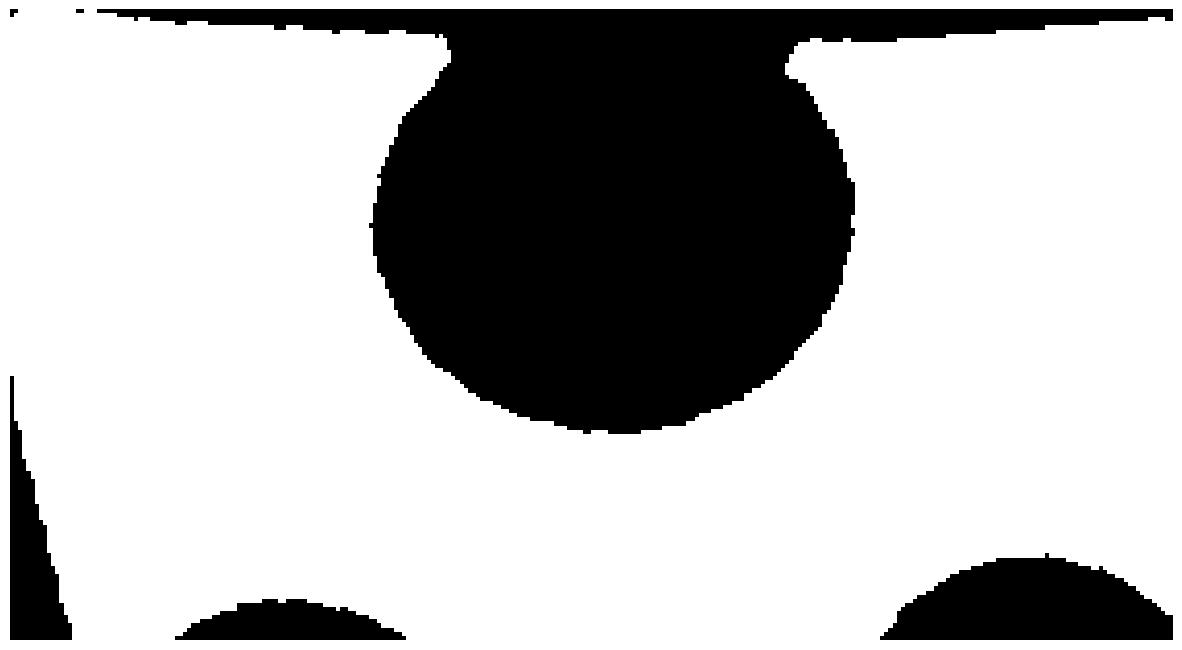

8.0
Hole


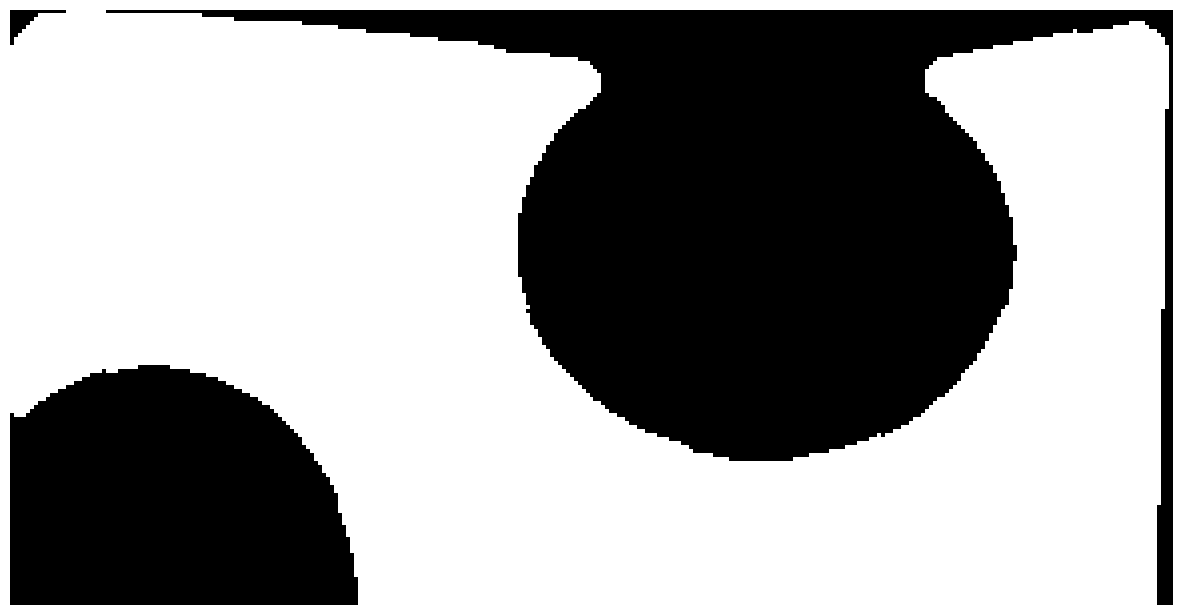

0.0
Flat


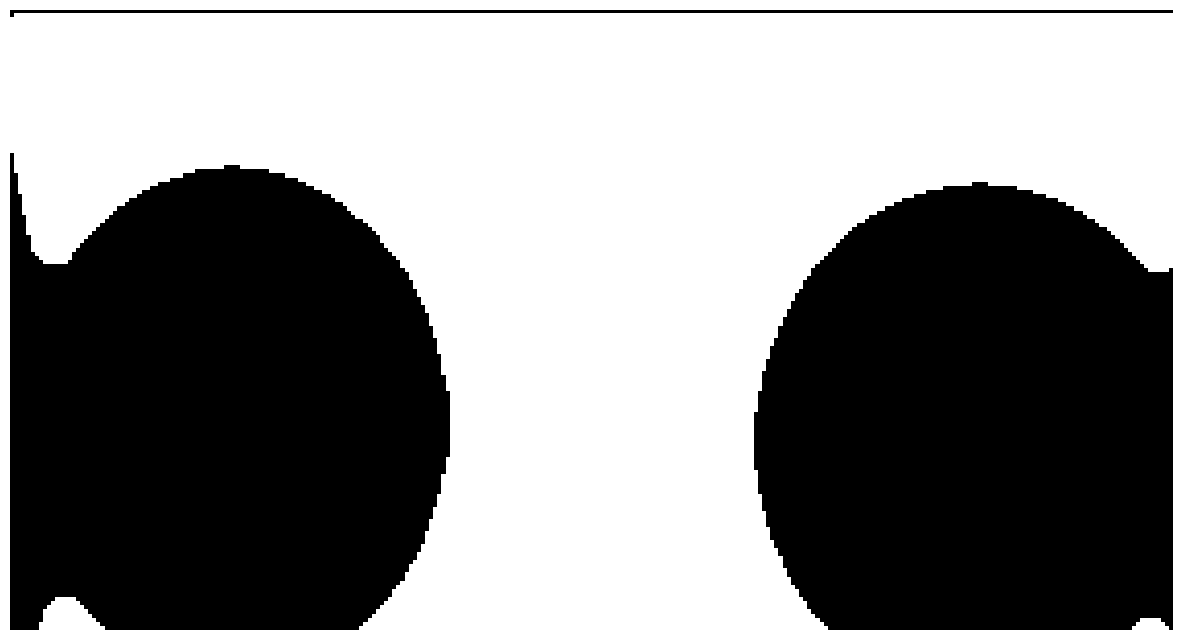

16.0
Hole


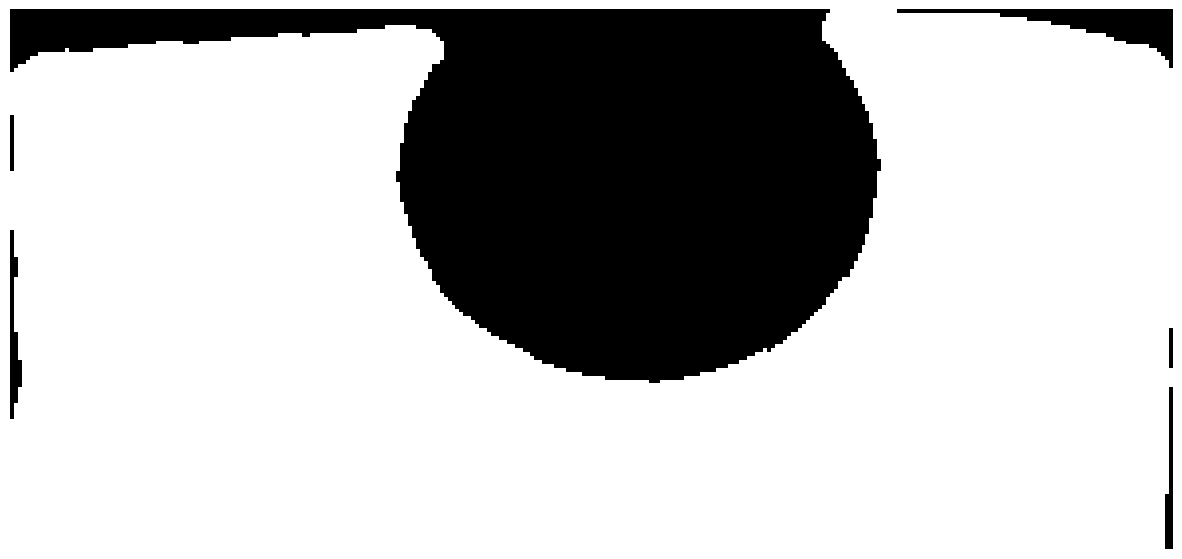

2.0
Flat


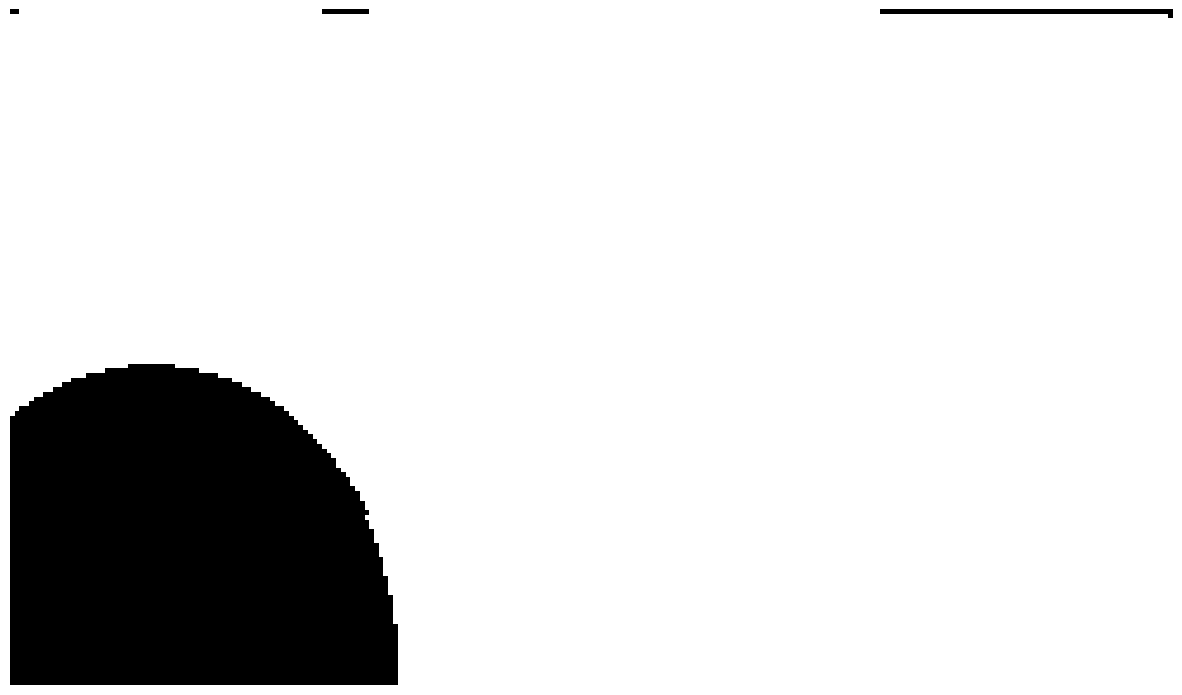

6.0
Flat


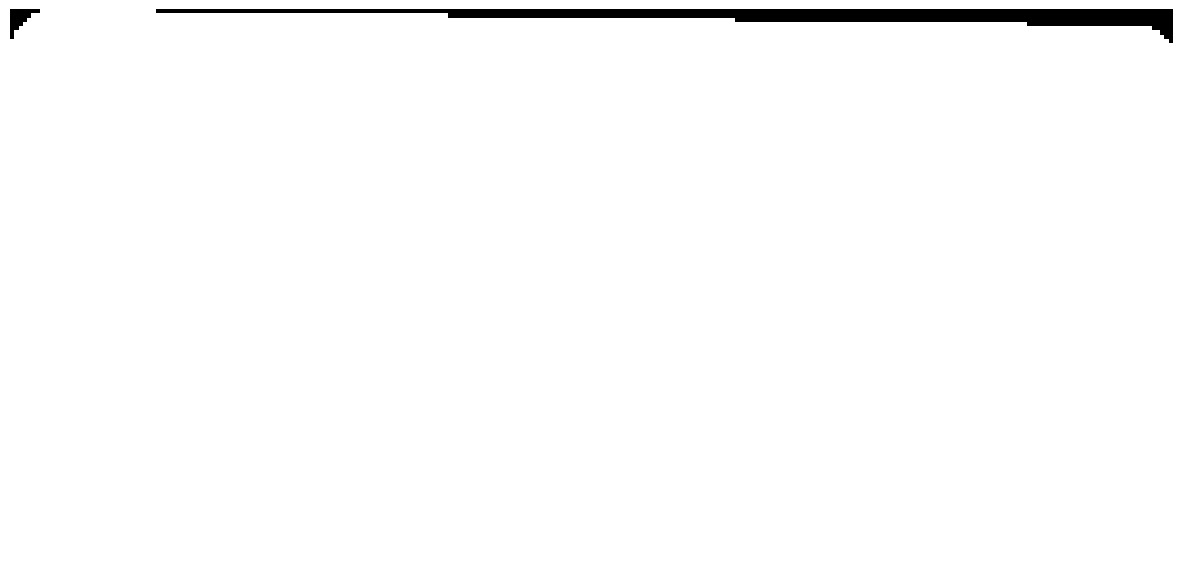

101.0
Head


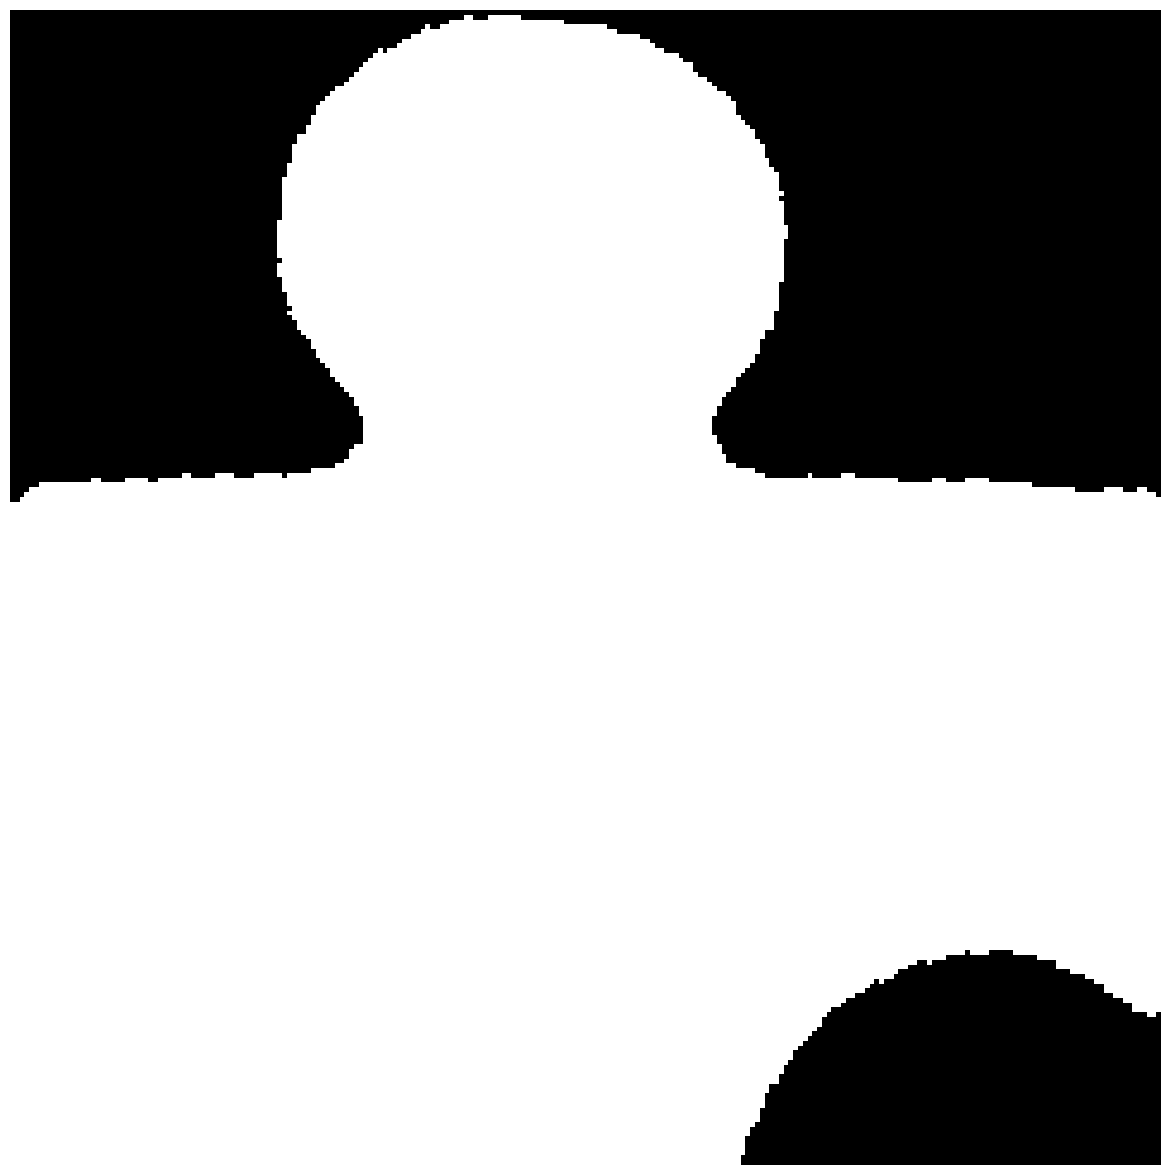

7.0
Hole


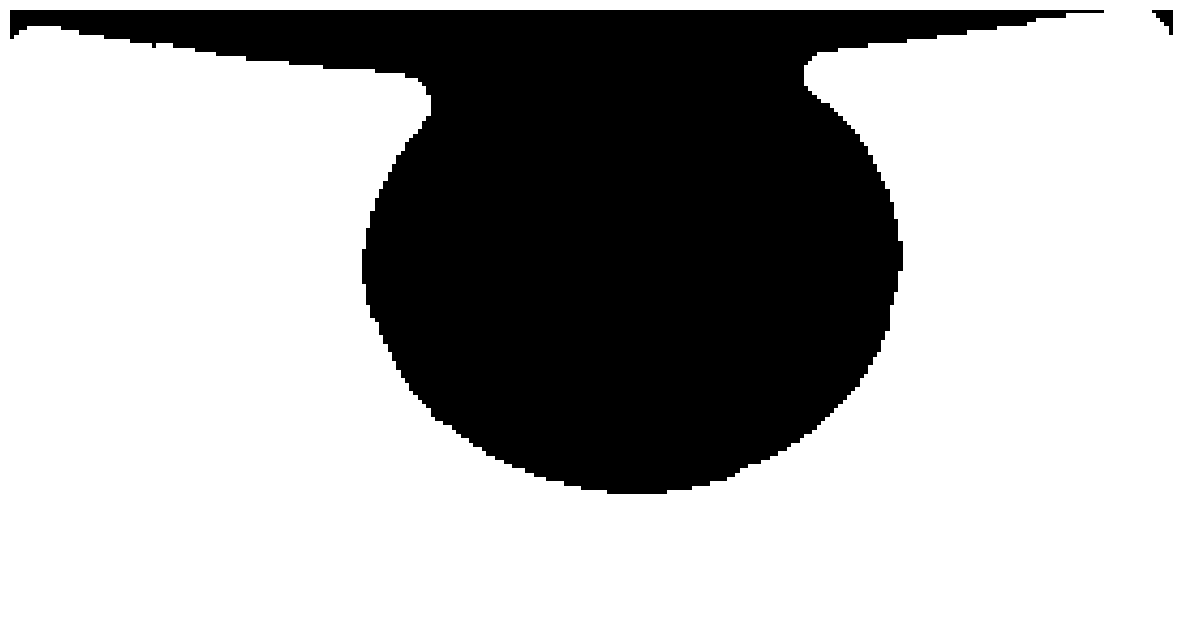

2.0
Flat


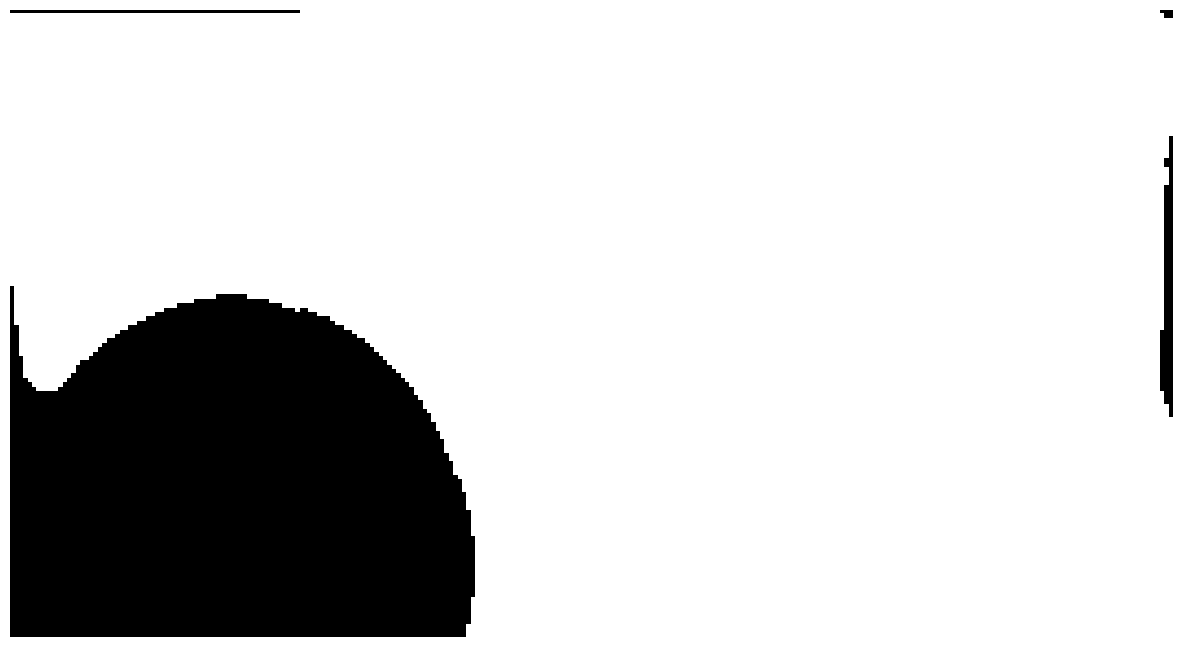

90.0
Head


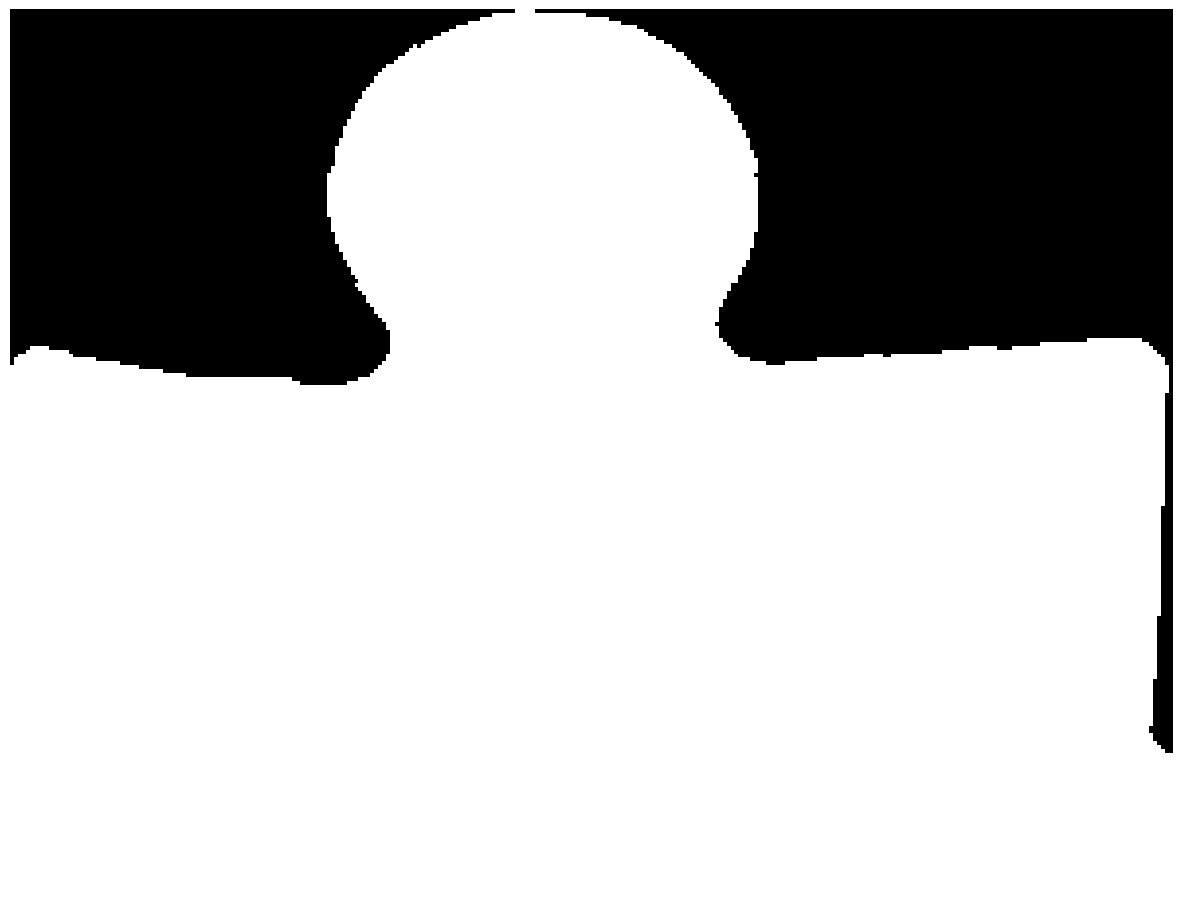

103.0
Head


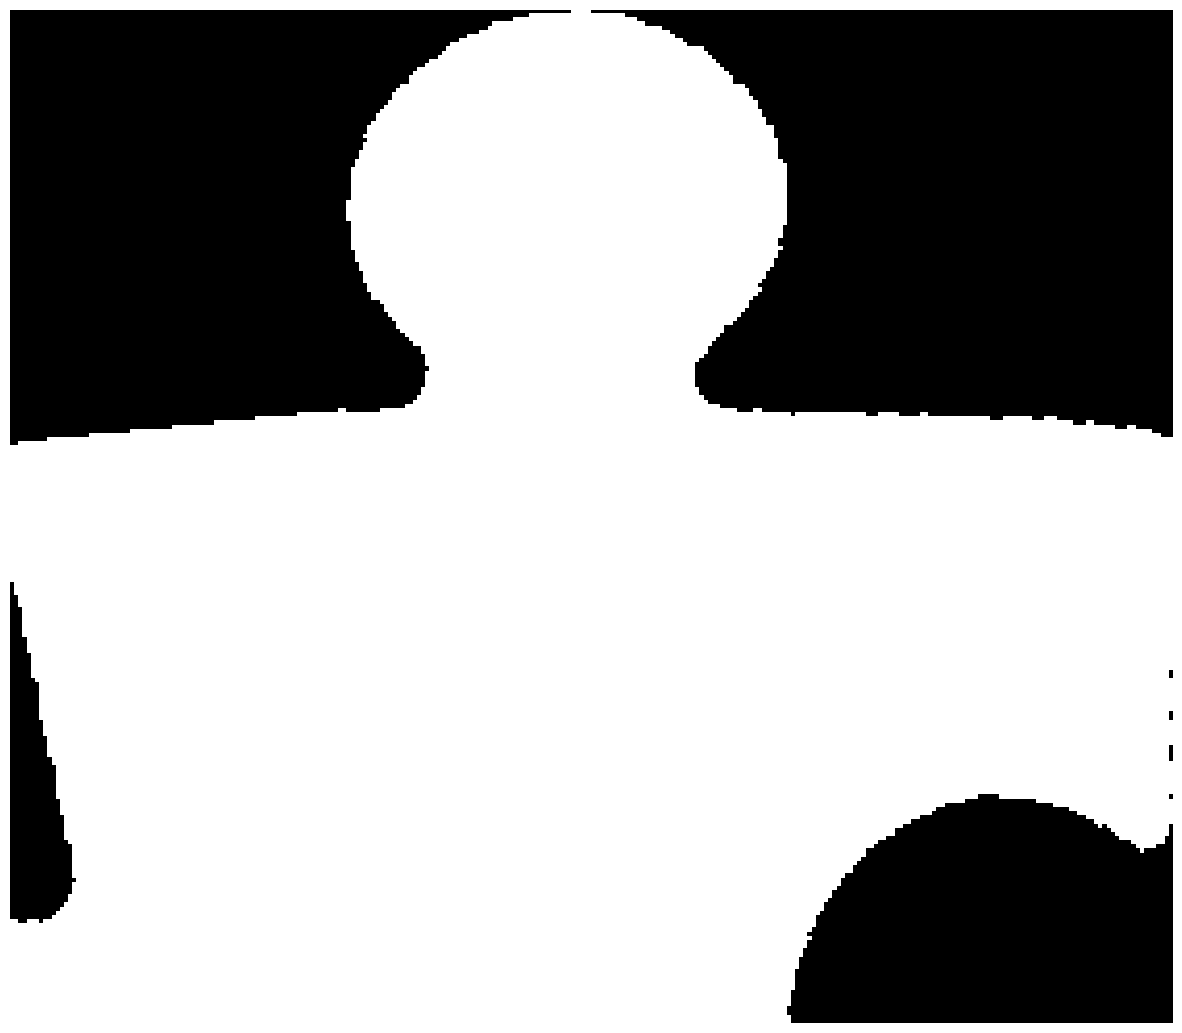

In [404]:
b_w_edges = []
for num, x in enumerate(pieces_side_points):
    piece_edges = []
    for i, y in enumerate(x):
        print(pieces_corner_dist[num][i])
        len1 = (int) (math.dist(y[0], y[1]))
        len2 = (int) (math.dist(y[1], y[2]))
        transform=[y[3][0], y[3][1], y[2][0], y[2][1], y[1][0], y[1][1], y[0][0], y[0][1]]
        
        img_copy = np.copy((universal_pieces[num]).piece_image_color)
        im = Image.fromarray(img_copy)
        result = im.transform((len2,len1), ImageTransform.QuadTransform(transform))
        img_copy = np.array(result)

        img_copy_bw = np.copy((universal_pieces[num]).piece_image_bw)
        img_copy_bw = img_copy_bw/255
        im = Image.fromarray(np.uint8(cm.gist_earth(img_copy_bw)*255))
        result = im.transform((len2,len1), ImageTransform.QuadTransform(transform))
        img_copy_bw = np.array(result)
        img_copy_bw = cv2.cvtColor(img_copy_bw, cv2.COLOR_BGR2GRAY)

        img_edge = Edges()
        
        height, width = img_copy_bw.shape
        val =0
        for i in range(width):
            j = 0
            while(j != height-1 and img_copy_bw[j][i]==0):
                j +=1
            val +=j
        if val < 1000: 
            print("Flat")
            img_edge.shape = Shape.Flat 
        elif val < 11000: 
            print("Hole")
            img_edge.shape = Shape.Hole
        else: 
            print("Head")
            img_edge.shape = Shape.Head
            #rotate 180
            # img_copy = np.rot90(np.rot90(img_copy))
            # img_copy_bw = np.rot90(np.rot90(img_copy_bw))

        
        img_edge.edge_image_color = img_copy
        img_edge.edge_image_bw = img_copy_bw

        show_gray(img_edge.edge_image_bw,"")
        # show(img_edge.edge_image_color,"")

        piece_edges.append(img_edge)
    (universal_pieces[num]).edges = piece_edges
    


